## ARCADE


### Baseline Comparisons
#### FP32 (Sigmoid vs Hardsigmoid & SiLU vs HardSwish)

In [7]:
import json
import pandas as pd
from IPython.display import display

# Paths to your result files
cifar_path = '/root/arcade/final_scripts/final_results/mobilenetv3_cifar10_baselines.json'
screw_path = '/root/arcade/final_scripts/final_results/mobilenetv3_screwset_baselines.json'

# Short names for variants
name_map = {
    'original':                                'Orig',
    'hardsigmoid_to_sigmoid':                 'Sig',
    'hardsigmoid_to_sigmoid_hardswish_to_silu': 'Sig+SiLU'
}

def load_and_build(path, dataset_prefix):
    with open(path) as f:
        data = json.load(f)
    records = []
    for e in data:
        variant = name_map.get(e['variant'], e['variant'])
        rec = {'Variant': variant, 'Test Acc': e['test_acc']}
        # flatten corrupt_results
        for corr_name, v in e['corrupt_results'].items():
            acc = v['acc'] if isinstance(v, dict) else v
            rec[corr_name] = acc
        records.append(rec)
    df = pd.DataFrame(records).set_index('Variant')
    # rename columns to avoid collisions
    df = df.rename(columns={c: f"{dataset_prefix} {c}" for c in df.columns})
    return df

# build tables
df_cifar = load_and_build(cifar_path, 'C10')
df_screw = load_and_build(screw_path, 'SCR')

# Display one below the other
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)

print("=== CIFAR-10 Baselines ===")
display(df_cifar)

print("\n=== ScrewSet Baselines ===")
display(df_screw)

=== CIFAR-10 Baselines ===


C10 Test Acc  C10 brightness  C10 contrast  C10 defocus_blur  \
Variant                                                                  
Orig             0.783           0.831         0.542             0.761   
Sig              0.782           0.817         0.597             0.760   
Sig+SiLU         0.738           0.708         0.431             0.618   

          C10 elastic_transform  C10 fog  C10 frost  C10 gaussian_blur  \
Variant                                                                  
Orig                      0.720    0.719      0.645              0.707   
Sig                       0.725    0.742      0.662              0.706   
Sig+SiLU                  0.614    0.580      0.560              0.559   

          C10 gaussian_noise  C10 glass_blur  C10 impulse_noise  \
Variant                                                           
Orig                   0.382           0.518              0.517   
Sig                    0.403           0.519              0.506   
Sig+SiLU               0.377           0.445              0.514   

          C10 jpeg_compression  C10 motion_blur  C10 pixelate  C10 saturate  \
Variant                                                                       
Orig                     0.798            0.645         0.787         0.802   
Sig                      0.790            0.667         0.753         0.800   
Sig+SiLU                 0.716            0.538         0.727         0.713   

          C10 shot_noise  C10 snow  C10 spatter  C10 speckle_noise  \
Variant                                                              
Orig               0.489     0.695        0.776              0.506   
Sig                0.505     0.684        0.768              0.522   
Sig+SiLU           0.448     0.630        0.703              0.463   

          C10 zoom_blur  
Variant                  
Orig              0.694  
Sig               0.685  
Sig+SiLU          0.557


=== ScrewSet Baselines ===


SCR Test Acc  SCR screwset_multi_object  \
Variant                                             
Orig             0.918                      0.225   
Sig              0.942                      0.243   
Sig+SiLU         0.926                      0.218   

          SCR screwset_occlusion_bottom_right  \
Variant                                         
Orig                                    0.025   
Sig                                     0.025   
Sig+SiLU                                0.025   

          SCR screwset_occlusion_top_left  SCR screwset_reflection  \
Variant                                                              
Orig                                0.025                    0.036   
Sig                                 0.030                    0.025   
Sig+SiLU                            0.027                    0.025   

          SCR screwset_scrap_paper  SCR screwset_shadow  
Variant                                                  
Orig                         0.127                0.023  
Sig                          0.257                0.025  
Sig+SiLU                     0.210                0.026

All MobileNetV3 baselines achieve **high clean accuracy** on both CIFAR-10 and Screwset, but **all variants fail under common corruptions and occlusions**. Changing activations (`hardsigmoid→sigmoid`, `hardswish→SiLU`) does **not improve robustness**. **Performance drops drastically** for all variants under real-world corruptions.

- **CIFAR-10:**
  - Clean test accuracy **~0.78** (`original` and `sigmoid`), drops to **~0.74** with `SiLU`.
  - Accuracy on corruptions like `gaussian_noise` and `glass_blur` is **below 0.52** for all.
  - No activation change leads to **meaningful robustness gains**.

- **Screwset:**
  - Clean accuracy **above 0.92** for all variants.
  - Accuracy under `occlusion`, `shadow`, or `reflection` often drops **below 0.03**.
  - Activation changes do **not address the robustness problem**.

Changing these layers also do not hurt the performance a lot, hence we are good to replace them for Hessian analysis.

### Quantization Comparisons for Cifar-10 and ScrewSet

In [8]:
import json
import pandas as pd

def load_and_flatten(path, dataset_name):
    with open(path) as f:
        data = json.load(f)
    records = []
    for rec in data:
        # compute mean corrupt accuracy
        corrupt = rec.get('corrupt_accuracy_per_type', {})
        mean_corr = sum(corrupt.values()) / len(corrupt) if corrupt else None
        records.append({
            'dataset': dataset_name,
            'replacement': rec['replacement'],
            'quant_type': rec['quant_type'],
            'weight_bw': rec['weight_bw'],
            'act_bw': rec['act_bw'],
            'clean_accuracy': rec['clean_accuracy'],
            'mean_corrupt_accuracy': mean_corr
        })
    return pd.DataFrame(records)

# paths to your quant results
cifar_path  = '/root/arcade/final_scripts/final_results/quant_results_matrix_cifar10.json'
screw_path  = '/root/arcade/final_scripts/final_results/quant_results_matrix_screwset.json'

# load
df_cifar = load_and_flatten(cifar_path,  'CIFAR-10')
df_screw = load_and_flatten(screw_path,  'ScrewSet')

# reorder columns for clarity
cols = ['dataset','replacement','quant_type','weight_bw','act_bw','clean_accuracy','mean_corrupt_accuracy']
df_cifar = df_cifar[cols]
df_screw = df_screw[cols]

# display one below the other
print("=== Quant Results: CIFAR-10 ===")
display(df_cifar.reset_index(drop=True))

print("\n=== Quant Results: ScrewSet ===")
display(df_screw.reset_index(drop=True))

=== Quant Results: CIFAR-10 ===


dataset                               replacement quant_type  weight_bw  \
0   CIFAR-10                                  original       FP32         32   
1   CIFAR-10                                  original        PTQ          8   
2   CIFAR-10                                  original        PTQ          8   
3   CIFAR-10                                  original        PTQ          4   
4   CIFAR-10                                  original       GPTQ          8   
5   CIFAR-10                                  original       GPTQ          8   
6   CIFAR-10                                  original       GPTQ          4   
7   CIFAR-10                    hardsigmoid_to_sigmoid       FP32         32   
8   CIFAR-10                    hardsigmoid_to_sigmoid        PTQ          8   
9   CIFAR-10                    hardsigmoid_to_sigmoid        PTQ          8   
10  CIFAR-10                    hardsigmoid_to_sigmoid        PTQ          4   
11  CIFAR-10                    hardsigmoid_to_sigmoid       GPTQ          8   
12  CIFAR-10                    hardsigmoid_to_sigmoid       GPTQ          8   
13  CIFAR-10                    hardsigmoid_to_sigmoid       GPTQ          4   
14  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu       FP32         32   
15  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          8   
16  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          8   
17  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          4   
18  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          8   
19  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          8   
20  CIFAR-10  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          4   

    act_bw  clean_accuracy  mean_corrupt_accuracy  
0       32           0.783                  0.660  
1        8           0.762                  0.626  
2        8           0.709                  0.538  
3        4           0.143                  0.132  
4        8           0.765                  0.636  
5        8           0.725                  0.565  
6        4           0.129                  0.122  
7       32           0.782                  0.664  
8        8           0.769                  0.635  
9        8           0.702                  0.551  
10       4           0.124                  0.119  
11       8           0.766                  0.635  
12       8           0.705                  0.553  
13       4           0.131                  0.126  
14      32           0.738                  0.574  
15       8           0.717                  0.563  
16       8           0.639                  0.487  
17       4           0.137                  0.131  
18       8           0.708                  0.550  
19       8           0.660                  0.505  
20       4           0.144                  0.132


=== Quant Results: ScrewSet ===


dataset                               replacement quant_type  weight_bw  \
0   ScrewSet                                  original       FP32         32   
1   ScrewSet                                  original        PTQ          8   
2   ScrewSet                                  original        PTQ          8   
3   ScrewSet                                  original        PTQ          4   
4   ScrewSet                                  original       GPTQ          8   
5   ScrewSet                                  original       GPTQ          8   
6   ScrewSet                                  original       GPTQ          4   
7   ScrewSet                    hardsigmoid_to_sigmoid       FP32         32   
8   ScrewSet                    hardsigmoid_to_sigmoid        PTQ          8   
9   ScrewSet                    hardsigmoid_to_sigmoid        PTQ          8   
10  ScrewSet                    hardsigmoid_to_sigmoid        PTQ          4   
11  ScrewSet                    hardsigmoid_to_sigmoid       GPTQ          8   
12  ScrewSet                    hardsigmoid_to_sigmoid       GPTQ          8   
13  ScrewSet                    hardsigmoid_to_sigmoid       GPTQ          4   
14  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu       FP32         32   
15  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          8   
16  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          8   
17  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu        PTQ          4   
18  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          8   
19  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          8   
20  ScrewSet  hardsigmoid_to_sigmoid_hardswish_to_silu       GPTQ          4   

    act_bw  clean_accuracy  mean_corrupt_accuracy  
0       32           0.918                  0.077  
1        8           0.906                  0.112  
2        8           0.791                  0.102  
3        4           0.025                  0.026  
4        8           0.923                  0.114  
5        8           0.861                  0.101  
6        4           0.025                  0.028  
7       32           0.942                  0.101  
8        8           0.933                  0.086  
9        8           0.795                  0.097  
10       4           0.025                  0.025  
11       8           0.937                  0.083  
12       8           0.855                  0.101  
13       4           0.025                  0.025  
14      32           0.926                  0.088  
15       8           0.883                  0.082  
16       8           0.809                  0.098  
17       4           0.050                  0.036  
18       8           0.878                  0.091  
19       8           0.786                  0.090  
20       4           0.042                  0.033

Quantized MobileNetV3 models keep **high clean accuracy** for FP8 (PTQ/GPTQ) on both CIFAR-10 and Screwset, but **robustness to corruptions remains very poor**, and **lower bit-width (FP4) destroys both clean and corrupt accuracy**. No quantization scheme fixes the fundamental lack of robustness.

- **CIFAR-10:**
  - FP32 and FP8 quantized models have clean accuracy **0.78–0.76**, but all show **major accuracy drops** on noise and blur corruptions (e.g. `gaussian_noise` < `0.38` even at FP32).
  - Going to FP4 (`PTQ_FP4_E2M1`, `GPTQ_FP4_E2M1`) drops clean and corrupt accuracy to **~0.13** for all corruptions.
  - No quantization variant yields **any meaningful improvement** in robustness.

- **Screwset:**
  - Clean accuracy for FP32 and FP8 models is **0.92–0.93**, but accuracy on real corruptions (occlusion, shadow, reflection) stays **below 0.04** for almost all cases.
  - FP4 models collapse: clean and corrupt accuracy fall to **~0.025**.
  - Quantization (PTQ/GPTQ) does **not address robustness failures** at all.


In [5]:
import json
import pandas as pd

# File path
json_path = "/root/arcade/final_scripts/final_results/quant_results_matrix_cifar10.json"

# List of all corruptions (include "clean" at the start)
CORRUPTIONS = [
    "clean", "brightness", "contrast", "defocus_blur", "elastic_transform",
    "fog", "frost", "gaussian_blur", "gaussian_noise", "glass_blur",
    "impulse_noise", "jpeg_compression", "motion_blur", "pixelate",
    "saturate", "shot_noise", "snow", "spatter", "speckle_noise", "zoom_blur"
]

# Load JSON data
with open(json_path, "r") as f:
    results = json.load(f)

# Build table: each row is one quant config for one model variant
table = []
for res in results:
    row = {
        "replacement": res["replacement"],
        "quant_type": res["quant_type"],
        "quant_name": res["quant_config"]["name"] if res.get("quant_config") else "FP32",
        "weight_bw": res["weight_bw"],
        "act_bw": res["act_bw"],
        "clean": res["clean_accuracy"]
    }
    # Add all corruptions (in order)
    for c in CORRUPTIONS[1:]:
        row[c] = res["corrupt_accuracy_per_type"].get(c, float("nan"))
    table.append(row)

df = pd.DataFrame(table)

# Add ΔAccuracy for each corruption relative to FP32 (per replacement/model)
dfs = []
for rep in df["replacement"].unique():
    df_rep = df[df["replacement"] == rep].copy()
    # Find FP32 row for this model variant
    fp32_row = df_rep[df_rep["quant_type"] == "FP32"].iloc[0]
    for c in CORRUPTIONS:
        df_rep[f"Δ{c}"] = df_rep[c] - fp32_row[c]
    dfs.append(df_rep)
df_full = pd.concat(dfs, ignore_index=True)

# Move Δ columns after each accuracy column for better readability
meta_cols = ["replacement", "quant_type", "quant_name", "weight_bw", "act_bw"]
cols = []
for c in CORRUPTIONS:
    cols.append(c)
    cols.append(f"Δ{c}")
df_full = df_full[meta_cols + cols]

# Save to CSV
csv_out = "/root/arcade/final_scripts/final_results/accuracy_table_with_deltas.csv"
df_full.to_csv(csv_out, index=False)
print(f"Saved to {csv_out}")

# Print a Markdown preview (first 3 rows)
print(df_full.to_markdown(index=False))  # See entire table in markdown

Saved to /root/arcade/final_scripts/final_results/accuracy_table_with_deltas.csv
| replacement                              | quant_type   | quant_name    |   weight_bw |   act_bw |    clean |     Δclean |   brightness |   Δbrightness |   contrast |   Δcontrast |   defocus_blur |   Δdefocus_blur |   elastic_transform |   Δelastic_transform |     fog |     Δfog |   frost |   Δfrost |   gaussian_blur |   Δgaussian_blur |   gaussian_noise |   Δgaussian_noise |   glass_blur |   Δglass_blur |   impulse_noise |   Δimpulse_noise |   jpeg_compression |   Δjpeg_compression |   motion_blur |   Δmotion_blur |   pixelate |   Δpixelate |   saturate |   Δsaturate |   shot_noise |   Δshot_noise |    snow |    Δsnow |   spatter |   Δspatter |   speckle_noise |   Δspeckle_noise |   zoom_blur |   Δzoom_blur |
|:-----------------------------------------|:-------------|:--------------|------------:|---------:|---------:|-----------:|-------------:|--------------:|-----------:|------------:|---------------

### Eff. Dim. Calculation CIFAR-10 and CIFAR-10-C

First, we check the hessian subsets to be used.

In [2]:
import os

# --- Clean set ---
clean_dir = '/root/arcade/data/cifar10_split/hessian_subset_test'
clean_total = 0
print("=== Clean set ===")
for dirpath, dirnames, filenames in os.walk(clean_dir):
    image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    clean_total += len(image_files)
    if image_files:
        print(f"{dirpath}: {len(image_files)} images")
print(f"Total images in {clean_dir}: {clean_total}\n")

# --- Corruption subsets ---
parent_dir = '/root/arcade/data/cifar10_split'
corruptions = [
    'brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost',
    'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression',
    'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur'
]

print("=== Corruption subsets ===")
grand_total = 0
for corruption in corruptions:
    subset_dir = os.path.join(parent_dir, f'hessian_subset_{corruption}')
    total_images = 0
    for dirpath, dirnames, filenames in os.walk(subset_dir):
        image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(image_files)
    print(f"{subset_dir}: {total_images} images")
    grand_total += total_images

print(f"\nTotal images in all corruption subsets: {grand_total}")
print(f"\nCombined total images (clean + corruptions): {clean_total + grand_total}")

=== Clean set ===
/root/arcade/data/cifar10_split/hessian_subset_test/automobile: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/cat: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/ship: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/frog: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/horse: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/deer: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/truck: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/airplane: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/bird: 100 images
/root/arcade/data/cifar10_split/hessian_subset_test/dog: 100 images
Total images in /root/arcade/data/cifar10_split/hessian_subset_test: 1000

=== Corruption subsets ===
/root/arcade/data/cifar10_split/hessian_subset_brightness: 200 images
/root/arcade/data/cifar10_split/hessian_subset_contrast: 200 images
/root/arcade/data/cifar10_split/hessian_su

Now we do the analysis of clean + corrupt hessian FP32 vs FP8.

In [21]:
import numpy as np
import os
import json
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit

# -------- SETTINGS --------
CORRUPTIONS = [
    "", "brightness", "contrast", "defocus_blur", "elastic_transform",
    "fog", "frost", "gaussian_blur", "gaussian_noise", "glass_blur",
    "impulse_noise", "jpeg_compression", "motion_blur", "pixelate",
    "saturate", "shot_noise", "snow", "spatter", "speckle_noise", "zoom_blur"
]
RESULTS_DIR = "/root/arcade/final_scripts/final_results/hessians/cifar10"
FP32_PREFIX = "eigs_fp32"
FP8_PREFIX = "eigs_fp8_e4m3"
Z_EFFDIM = 1  # Use the same z as in your pipeline

# -------- LOAD ACCURACIES FROM JSON --------
def get_acc_dicts(json_path, replacement="hardsigmoid_to_sigmoid"):
    with open(json_path, "r") as f:
        all_res = json.load(f)
    acc_map_fp32, acc_map_fp8 = {}, {}
    for res in all_res:
        if res["replacement"] == replacement and res["quant_type"] == "FP32":
            acc_map_fp32[""] = res["clean_accuracy"]
            acc_map_fp32.update(res["corrupt_accuracy_per_type"])
        if res["replacement"] == replacement and res["quant_type"] == "PTQ" and \
            res.get("quant_config",{}).get("name") == "PTQ_FP8_E4M3":
            acc_map_fp8[""] = res["clean_accuracy"]
            acc_map_fp8.update(res["corrupt_accuracy_per_type"])
    return acc_map_fp32, acc_map_fp8

ACC_JSON = "/root/arcade/final_scripts/final_results/quant_results_matrix_cifar10.json"
acc_map_fp32, acc_map_fp8 = get_acc_dicts(ACC_JSON)

# -------- METRIC FUNCTIONS --------
def metrics(eigs, z=Z_EFFDIM):
    eigs = np.sort(eigs)[::-1]
    eigsum = eigs.sum()
    trace = eigsum
    l1 = eigs[0]
    head10 = eigs[:10].sum() / eigsum
    tail = eigs[10:].sum() / eigsum
    pr = (eigsum**2) / (np.square(eigs).sum())
    p = eigs / eigsum
    # -- Robust spectral entropy calculation --
    if np.all(p == 0) or np.isnan(p).any():
        spectral_entropy = np.nan
    else:
        p_nonzero = p[p > 0]
        spectral_entropy = -np.sum(p_nonzero * np.log(p_nonzero))
    kappa = eigs[0] / eigs[-1]
    neff = (eigs / (eigs + z)).sum()
    return dict(
        trace=trace,
        largest_eig=l1,
        head10=head10,
        tail=tail,
        pr=pr,
        spectral_entropy=spectral_entropy,
        kappa=kappa,
        neff=neff
    )

def power_law_alpha(eigs):
    eigs = np.sort(eigs)[::-1]
    x = np.arange(1, len(eigs) + 1)
    y = eigs
    mask = y > 0
    logx = np.log(x[mask])
    logy = np.log(y[mask])
    def lin(x, a, b): return a * x + b
    a, _ = curve_fit(lin, logx, logy)[0]
    return -a

# -------- MAIN: COLLECT METRICS --------
results = []
for corr in CORRUPTIONS:
    fn_fp32 = os.path.join(RESULTS_DIR, f"{FP32_PREFIX}.npy" if corr=="" else f"{FP32_PREFIX}_{corr}.npy")
    fn_fp8 = os.path.join(RESULTS_DIR, f"{FP8_PREFIX}.npy" if corr=="" else f"{FP8_PREFIX}_{corr}.npy")
    if not (os.path.exists(fn_fp32) and os.path.exists(fn_fp8)):
        print(f"Skipping {corr if corr else 'clean'}: missing file(s)")
        continue
    eigs_fp32 = np.load(fn_fp32)
    eigs_fp8 = np.load(fn_fp8)

    m_fp32 = metrics(eigs_fp32, Z_EFFDIM)
    m_fp8 = metrics(eigs_fp8, Z_EFFDIM)
    delta = {k: m_fp8[k] - m_fp32[k] for k in m_fp32}
    try:
        alpha_fp32 = power_law_alpha(eigs_fp32)
        alpha_fp8 = power_law_alpha(eigs_fp8)
        delta['alpha'] = alpha_fp8 - alpha_fp32
    except Exception:
        alpha_fp32 = alpha_fp8 = np.nan

    acc_fp32 = acc_map_fp32.get(corr, np.nan)
    acc_fp8 = acc_map_fp8.get(corr, np.nan)
    delta_acc = acc_fp8 - acc_fp32

    results.append({
        'corruption': "clean" if corr=="" else corr,
        'fp32': m_fp32,
        'fp8': m_fp8,
        'delta': delta,
        'acc_fp32': acc_fp32,
        'acc_fp8': acc_fp8,
        'delta_acc': delta_acc,
        'alpha_fp32': alpha_fp32,
        'alpha_fp8': alpha_fp8
    })

# -------- SUMMARY TABLE --------
summary = []
for r in results:
    s = {'corruption': r['corruption'], 'ΔAccuracy': r['delta_acc']}
    for k in r['delta']:
        s[f'Δ{k}'] = r['delta'][k]
    summary.append(s)
df = pd.DataFrame(summary)
print(df.round(5))

# -------- CORRELATIONS --------
metrics_of_interest = ['Δtrace', 'Δneff', 'Δpr', 'Δhead10', 'Δtail', 'Δalpha']
for m in metrics_of_interest:
    if m in df.columns:
        vals = df[m].values
        corr_spear, _ = spearmanr(vals, df['ΔAccuracy'])
        corr_pear, _ = pearsonr(vals, df['ΔAccuracy'])
        print(f"{m} vs ΔAccuracy: Spearman={corr_spear:.3f}, Pearson={corr_pear:.3f}")

# -------- SAVE TO CSV --------
csv_path = os.path.join(RESULTS_DIR, "spectrum_metrics_delta_summary_cifar10.csv")
df.to_csv(csv_path, index=False)
print(f"Saved CSV to: {csv_path}")

           corruption  ΔAccuracy        Δtrace  Δlargest_eig  Δhead10  \
0               clean   -0.01350  -8166.785156  -1532.040527 -0.09046   
1          brightness   -0.01932 -10297.519531  -1677.335327 -0.11645   
2            contrast   -0.03212 -16586.271484  -3328.054199 -0.07110   
3        defocus_blur   -0.01486  -9570.213867  -2683.385254 -0.11294   
4   elastic_transform   -0.01834 -18715.710938  -5159.213379 -0.13412   
5                 fog   -0.04782 -12563.362305  -2017.011719 -0.03929   
6               frost   -0.03632 -13973.597656  -1736.346191 -0.03929   
7       gaussian_blur   -0.01710 -10866.576172  -2226.247559 -0.11146   
8      gaussian_noise   -0.03558 -19832.792969  -4828.610352 -0.04646   
9          glass_blur   -0.05740 -17103.279297  -2522.386963 -0.10779   
10      impulse_noise   -0.01666 -20979.171875  -2603.332764 -0.00407   
11   jpeg_compression   -0.02608  -7916.324707  -1256.658447 -0.07816   
12        motion_blur   -0.01936 -12164.345703  -27

### Eff Dim. Analysis of Screwset and Screwset-c

In [6]:
import os

# --- Clean set for Screwset ---
clean_dir = '/root/arcade/data/screwset_split/hessian_subset'
clean_total = 0
print("=== Clean set (Screwset) ===")
for dirpath, dirnames, filenames in os.walk(clean_dir):
    image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    clean_total += len(image_files)
    if image_files:
        print(f"{dirpath}: {len(image_files)} images")
print(f"Total images in {clean_dir}: {clean_total}\n")

=== Clean set (Screwset) ===
/root/arcade/data/screwset_split/hessian_subset/M4.2_20_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_30_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_18_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_30_Round: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_18_Round: 50 images
/root/arcade/data/screwset_split/hessian_subset/M5_20_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_16_Round: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4_8_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M6_20_Round: 50 images
/root/arcade/data/screwset_split/hessian_subset/M5_16_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/7#_40_Yellow: 50 images
/root/arcade/data/screwset_split/hessian_subset/M3_10_Flat: 50 images
/root/arcade/data/screwset_split/hessian_subset/M3_10_Round: 50 images
/root/arcade/data/screwset_split/hessian_subset/M4.2_

In [22]:
import numpy as np
import os
import json
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit

# -------- SETTINGS --------
RESULTS_DIR = "/root/arcade/final_scripts/final_results/hessians/screwset"
ACC_JSON = "/root/arcade/final_scripts/final_results/quant_results_matrix_screwset.json"
CLEAN_FP32 = "eigs_fp32_screwset.npy"
CLEAN_FP8  = "eigs_fp8_e4m3_screwset.npy"
FP32_PREFIX = "eigs_fp32_screwset_hessian_subset"
FP8_PREFIX = "eigs_fp8_e4m3_screwset_hessian_subset"
Z_EFFDIM = 1
CORRUPTIONS = [
    "clean",
    "screwset_multi_object",
    "screwset_occlusion_bottom_right",
    "screwset_occlusion_top_left",
    "screwset_reflection",
    "screwset_scrap_paper",
    "screwset_shadow"
]

# -------- LOAD ACCURACIES FROM JSON --------
def get_acc_dicts(json_path, replacement="hardsigmoid_to_sigmoid"):
    with open(json_path, "r") as f:
        all_res = json.load(f)
    acc_map_fp32 = {}
    acc_map_fp8 = {}
    for res in all_res:
        if res["replacement"] == replacement and res["quant_type"] == "FP32":
            acc_map_fp32["clean"] = res["clean_accuracy"]
            acc_map_fp32.update(res["corrupt_accuracy_per_type"])
        if res["replacement"] == replacement and res["quant_type"] == "PTQ" and \
           res.get("quant_config", {}).get("name") == "PTQ_FP8_E4M3":
            acc_map_fp8["clean"] = res["clean_accuracy"]
            acc_map_fp8.update(res["corrupt_accuracy_per_type"])
    return acc_map_fp32, acc_map_fp8

acc_map_fp32, acc_map_fp8 = get_acc_dicts(ACC_JSON)

# -------- METRIC FUNCTIONS --------
def metrics(eigs, z=Z_EFFDIM):
    eigs = np.sort(eigs)[::-1]
    eigsum = eigs.sum()
    trace = eigsum
    l1 = eigs[0]
    head10 = eigs[:10].sum() / eigsum
    tail = eigs[10:].sum() / eigsum
    pr = (eigsum**2) / (np.square(eigs).sum())
    p = eigs / eigsum
    # --- Robust spectral entropy ---
    if np.all(p == 0) or np.isnan(p).any():
        spectral_entropy = np.nan
    else:
        p_nonzero = p[p > 0]
        spectral_entropy = -np.sum(p_nonzero * np.log(p_nonzero))
    kappa = eigs[0] / eigs[-1]
    neff = (eigs / (eigs + z)).sum()
    return dict(
        trace=trace,
        largest_eig=l1,
        head10=head10,
        tail=tail,
        pr=pr,
        spectral_entropy=spectral_entropy,
        kappa=kappa,
        neff=neff
    )

def power_law_alpha(eigs):
    eigs = np.sort(eigs)[::-1]
    x = np.arange(1, len(eigs) + 1)
    y = eigs
    mask = y > 0
    logx = np.log(x[mask])
    logy = np.log(y[mask])
    def lin(x, a, b): return a * x + b
    a, _ = curve_fit(lin, logx, logy)[0]
    return -a

# -------- MAIN: COLLECT METRICS --------
results = []
for corr in CORRUPTIONS:
    if corr == "clean":
        fp32_path = os.path.join(RESULTS_DIR, CLEAN_FP32)
        fp8_path = os.path.join(RESULTS_DIR, CLEAN_FP8)
    else:
        fp32_path = os.path.join(RESULTS_DIR, f"{FP32_PREFIX}_{corr}.npy")
        fp8_path  = os.path.join(RESULTS_DIR, f"{FP8_PREFIX}_{corr}.npy")
    if not (os.path.exists(fp32_path) and os.path.exists(fp8_path)):
        print(f"Skipping {corr}: missing file(s): {fp32_path}, {fp8_path}")
        continue
    eigs_fp32 = np.load(fp32_path)
    eigs_fp8 = np.load(fp8_path)

    m_fp32 = metrics(eigs_fp32, Z_EFFDIM)
    m_fp8 = metrics(eigs_fp8, Z_EFFDIM)
    delta = {k: m_fp8[k] - m_fp32[k] for k in m_fp32}
    try:
        alpha_fp32 = power_law_alpha(eigs_fp32)
        alpha_fp8 = power_law_alpha(eigs_fp8)
        delta['alpha'] = alpha_fp8 - alpha_fp32
    except Exception:
        alpha_fp32 = alpha_fp8 = np.nan

    acc_fp32 = acc_map_fp32.get(corr, np.nan)
    acc_fp8 = acc_map_fp8.get(corr, np.nan)
    delta_acc = acc_fp8 - acc_fp32

    results.append({
        'corruption': corr,
        'fp32': m_fp32,
        'fp8': m_fp8,
        'delta': delta,
        'acc_fp32': acc_fp32,
        'acc_fp8': acc_fp8,
        'delta_acc': delta_acc,
        'alpha_fp32': alpha_fp32,
        'alpha_fp8': alpha_fp8
    })

# -------- SUMMARY TABLE --------
summary = []
for r in results:
    s = {'corruption': r['corruption'], 'ΔAccuracy': r['delta_acc']}
    for k in r['delta']:
        s[f'Δ{k}'] = r['delta'][k]
    summary.append(s)
df = pd.DataFrame(summary)
print(df.round(5))

# -------- CORRELATIONS --------
metrics_of_interest = ['Δtrace', 'Δneff', 'Δpr', 'Δhead10', 'Δtail', 'Δalpha']
for m in metrics_of_interest:
    if m in df.columns:
        vals = df[m].values
        corr_spear, _ = spearmanr(vals, df['ΔAccuracy'])
        corr_pear, _ = pearsonr(vals, df['ΔAccuracy'])
        print(f"{m} vs ΔAccuracy: Spearman={corr_spear:.3f}, Pearson={corr_pear:.3f}")

# -------- SAVE TO CSV --------
csv_path = os.path.join(RESULTS_DIR, "spectrum_metrics_delta_summary_screwset.csv")
df.to_csv(csv_path, index=False)
print(f"Saved CSV to: {csv_path}")

                        corruption  ΔAccuracy        Δtrace  Δlargest_eig  \
0                            clean   -0.00835 -5.970111e+04 -1.066128e+03   
1            screwset_multi_object   -0.01484  1.017848e+05 -6.977510e+02   
2  screwset_occlusion_bottom_right    0.00078  1.041668e+07 -1.599589e+05   
3      screwset_occlusion_top_left   -0.00547 -1.959710e+07 -4.192144e+05   
4              screwset_reflection    0.00000 -7.926126e+07 -3.091509e+06   
5             screwset_scrap_paper   -0.07109  1.894687e+05  2.557228e+03   
6                  screwset_shadow    0.00000 -2.542963e+07 -9.050131e+05   

   Δhead10    Δtail       Δpr  Δspectral_entropy    Δkappa    Δneff   Δalpha  
0  0.00377 -0.00377  -4.67614           -0.02983  13.72891  0.12694 -0.03696  
1 -0.02923  0.02923   8.88051            0.01895  -1.48231 -0.08880  0.04853  
2 -0.26882  0.26882 -13.13547            2.08331  -0.41732 -0.00674  0.18553  
3  0.04089 -0.04089  -8.82655            0.28672   0.92244 -0.00931

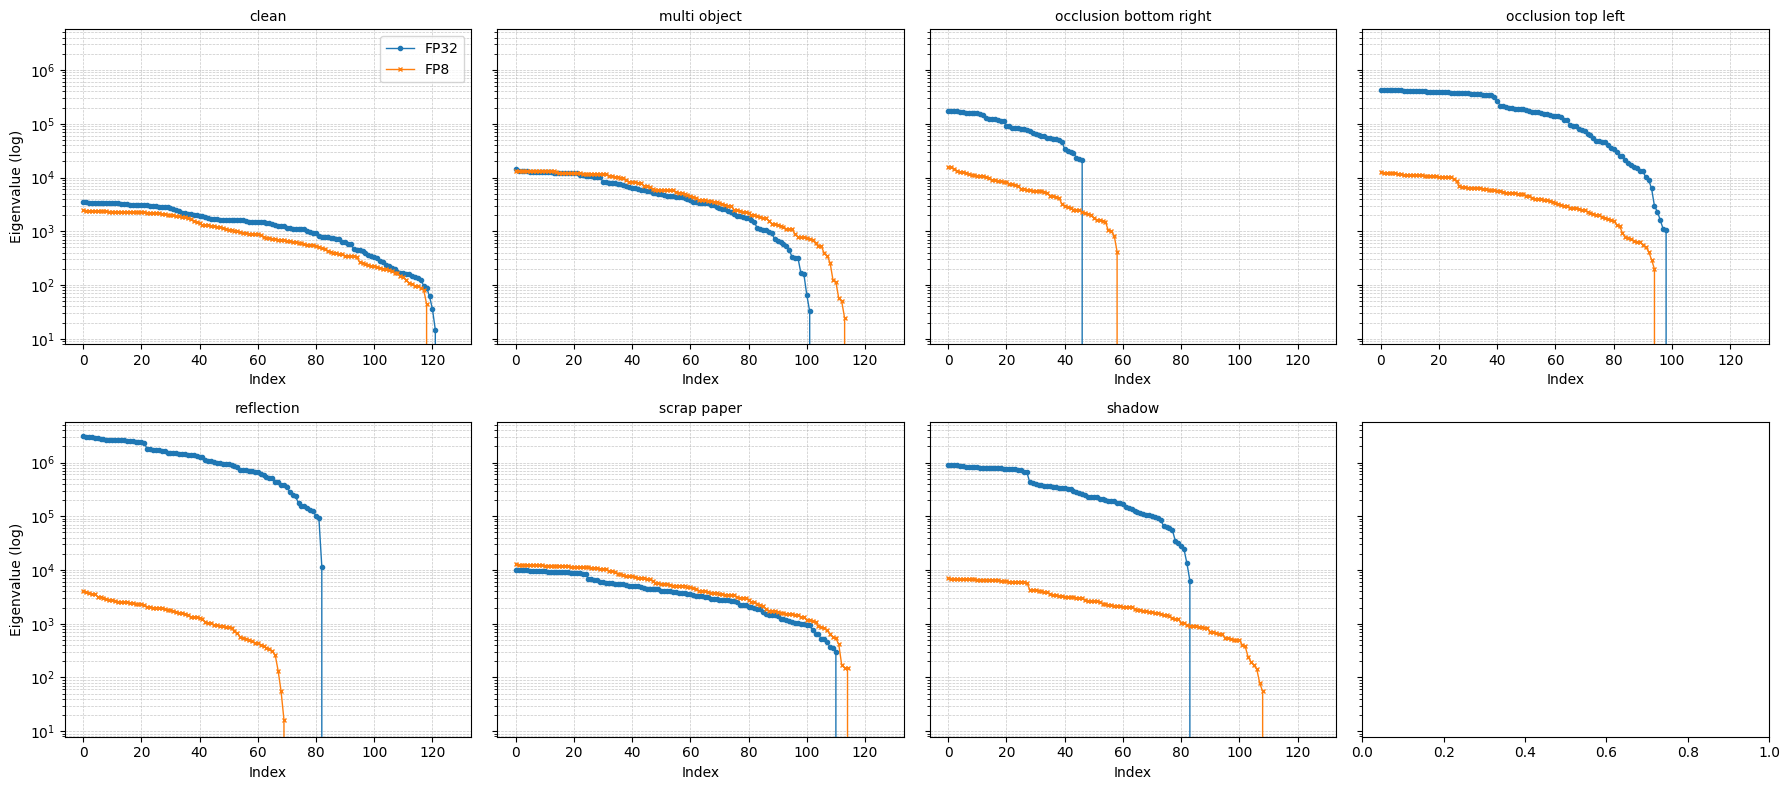

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

RESULTS_DIR = "/root/arcade/final_scripts/final_results/hessians/screwset"
CORRUPTIONS = [
    "clean",
    "screwset_multi_object",
    "screwset_occlusion_bottom_right",
    "screwset_occlusion_top_left",
    "screwset_reflection",
    "screwset_scrap_paper",
    "screwset_shadow"
]
CLEAN_FP32 = "eigs_fp32_screwset.npy"
CLEAN_FP8  = "eigs_fp8_e4m3_screwset.npy"
FP32_PREFIX = "eigs_fp32_screwset_hessian_subset"
FP8_PREFIX = "eigs_fp8_e4m3_screwset_hessian_subset"

fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for idx, corr in enumerate(CORRUPTIONS):
    if corr == "clean":
        fp32_path = os.path.join(RESULTS_DIR, CLEAN_FP32)
        fp8_path  = os.path.join(RESULTS_DIR, CLEAN_FP8)
        title = "clean"
    else:
        fp32_path = os.path.join(RESULTS_DIR, f"{FP32_PREFIX}_{corr}.npy")
        fp8_path  = os.path.join(RESULTS_DIR, f"{FP8_PREFIX}_{corr}.npy")
        title = corr.replace("screwset_", "").replace("_", " ")

    if not (os.path.exists(fp32_path) and os.path.exists(fp8_path)):
        axes[idx].set_visible(False)
        continue

    eigs_fp32 = np.sort(np.load(fp32_path))[::-1]
    eigs_fp8  = np.sort(np.load(fp8_path))[::-1]
    axes[idx].plot(eigs_fp32, label="FP32", marker='o', markersize=3, linewidth=1)
    axes[idx].plot(eigs_fp8,  label="FP8", marker='x', markersize=3, linewidth=1)
    axes[idx].set_yscale('log')
    axes[idx].set_title(title, fontsize=10)
    axes[idx].grid(True, which='both', ls='--', lw=0.5, alpha=0.7)
    if idx % 4 == 0:
        axes[idx].set_ylabel("Eigenvalue (log)")
    axes[idx].set_xlabel("Index")

# Only put legend on the first subplot
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "spectrum_plot_screwset_all.png"), dpi=200)
plt.show()

Comparison of analysis of both datasets.


ScrewSet-C
                   Pearson  Spearman
metric                              
Δlargest_eig        -0.361    -0.775
Δpr                 -0.074    -0.468
Δtrace              -0.320    -0.234
Δhead10              0.084    -0.234
Δneff               -0.161    -0.162
Δalpha              -0.237    -0.036
Δkappa               0.153     0.072
Δtail               -0.084     0.234
Δspectral_entropy    0.335     0.396

CIFAR-10-C
                   Pearson  Spearman
metric                              
Δneff               -0.514    -0.486
Δhead10             -0.224    -0.165
Δlargest_eig        -0.027     0.014
Δkappa              -0.027     0.014
Δtail                0.224     0.165
Δspectral_entropy    0.258     0.223
Δpr                  0.301     0.304
Δalpha               0.248     0.323
Δtrace               0.338     0.379

Saved correlation tables and scatter figure to /root/arcade/final_scripts/final_results/hessians


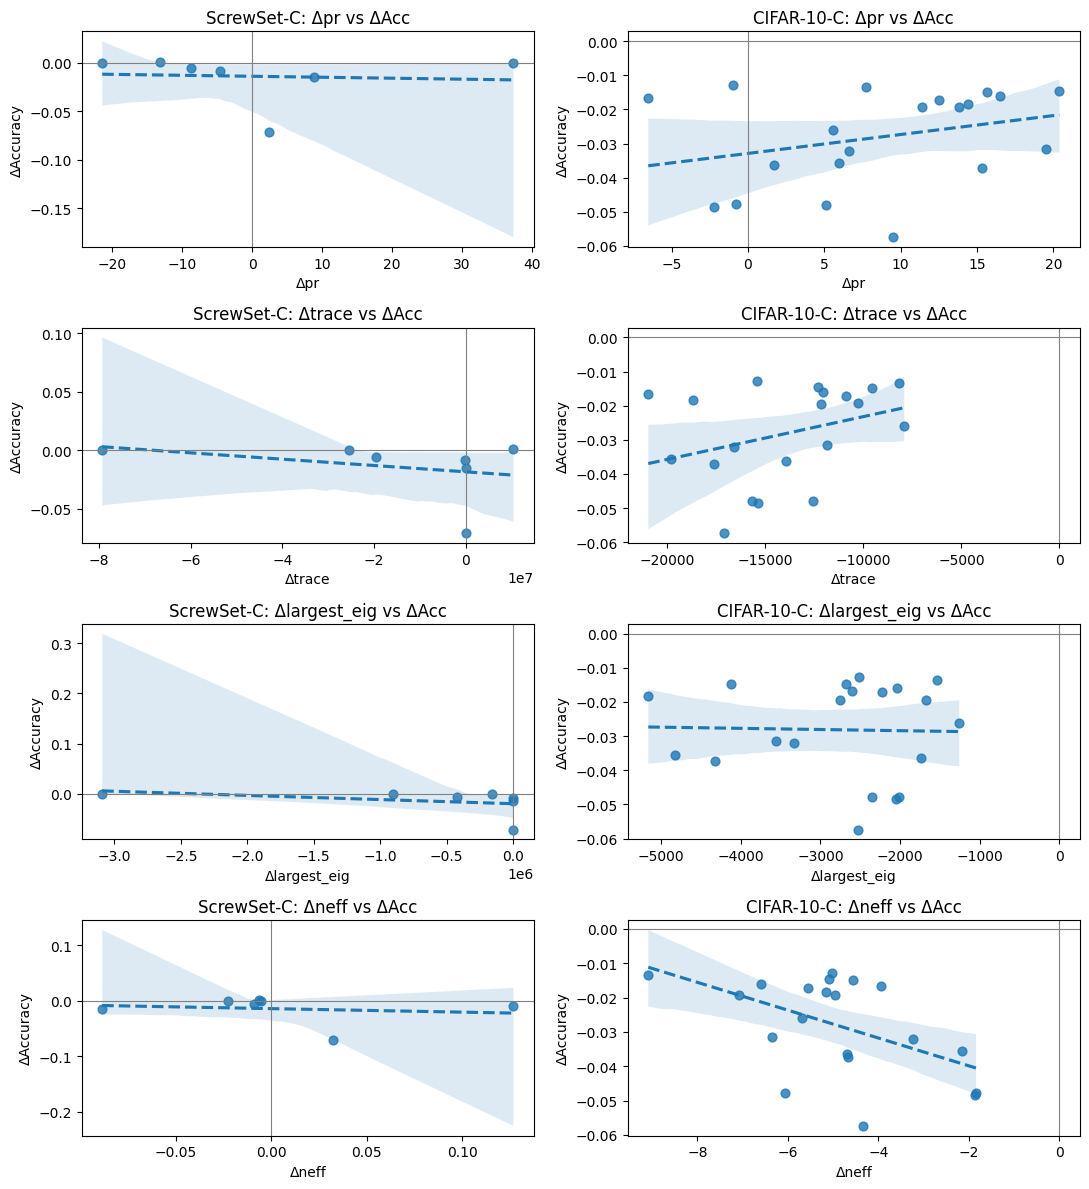

In [29]:
#!/usr/bin/env python3
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import pearsonr, spearmanr
from pathlib import Path

# ---------------------------------------------------------------- paths ----
ROOT = Path("/root/arcade/final_scripts/final_results/hessians")
CSV = {
    "ScrewSet-C" : ROOT / "screwset" / "spectrum_metrics_delta_summary_screwset.csv",
    "CIFAR-10-C": ROOT / "cifar10"  / "spectrum_metrics_delta_summary_cifar10.csv",
}
OUT_DIR = ROOT          # change if you prefer another folder
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ---------------------------------------------------------- correlations ----
def corr_table(df):
    rows = []
    for col in df.filter(regex=r"^Δ").columns:
        if col == "ΔAccuracy": continue
        x, y = df[col], df["ΔAccuracy"]
        mask = x.notna() & y.notna()
        if mask.sum() < 3: continue
        rows.append({
            "metric"   : col,
            "Pearson"  : pearsonr(x[mask],  y[mask])[0],
            "Spearman" : spearmanr(x[mask], y[mask])[0],
        })
    return (pd.DataFrame(rows)
              .set_index("metric")
              .sort_values("Spearman"))

all_tables = []
for name, path in CSV.items():
    tb = corr_table(pd.read_csv(path))
    print(f"\n{name}\n{tb.round(3)}")
    tb.to_csv(OUT_DIR / f"corr_table_{name}.csv")
    tb["dataset"] = name
    all_tables.append(tb.reset_index())

# combined CSV (optional)
pd.concat(all_tables, ignore_index=True).to_csv(OUT_DIR / "corr_table_combined.csv", index=False)

# ----------------------------------------- scatter figure ----
metrics = ["Δpr", "Δtrace", "Δlargest_eig", "Δneff"]
fig, axes = plt.subplots(len(metrics), len(CSV), figsize=(11, 3*len(metrics)))
for r, m in enumerate(metrics):
    for c, (name, path) in enumerate(CSV.items()):
        df = pd.read_csv(path)
        ax = axes[r, c] if len(metrics) > 1 else axes[c]
        sns.regplot(data=df, x=m, y="ΔAccuracy",
                    ax=ax, scatter_kws=dict(s=40), line_kws=dict(ls="--"))
        ax.set_title(f"{name}: {m} vs ΔAcc")
        ax.axhline(0, c="grey", lw=.8); ax.axvline(0, c="grey", lw=.8)
fig.tight_layout()
fig.savefig(OUT_DIR / "correlation_scatter.png", dpi=300)
print(f"\nSaved correlation tables and scatter figure to {OUT_DIR}")


#### ImageNet Evaluation

Check number of samples.

In [4]:
import os

corruptions_dir = "/mnt/ssd/workspace/arcade_data/corruptions"

for corruption in sorted(os.listdir(corruptions_dir)):
    corr_path = os.path.join(corruptions_dir, corruption)
    if not os.path.isdir(corr_path):
        continue
    for severity in sorted(os.listdir(corr_path)):
        sev_path = os.path.join(corr_path, severity)
        if os.path.isdir(sev_path):
            for class_name in sorted(os.listdir(sev_path)):
                class_path = os.path.join(sev_path, class_name)
                if os.path.isdir(class_path):
                    num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                    if num_files != 50:
                        print(f"{corruption} - severity {severity} - class {class_name}: {num_files} files")

We need to prepare a the validation set first.

In [ ]:
import os
import shutil
from scipy.io import loadmat
from tqdm import tqdm  # <-- added

# --- Set your paths ---
IMAGENET_VAL_DIR = '/mnt/ssd/workspace/arcade_data/val'
META_MAT_FILE = '/mnt/ssd/workspace/arcade_data/ILSVRC2012_devkit_t12/data/meta.mat'
GROUND_TRUTH_FILE = '/mnt/ssd/workspace/arcade_data/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt'

def reorganize_validation_set():
    # 1. Read meta.mat and build ILSVRC_ID to WNID mapping
    meta = loadmat(META_MAT_FILE, squeeze_me=True)
    synsets = meta['synsets']

    id_to_wnid = {}
    for s in synsets:
        ilsvrc_id = int(s[0])
        wnid = str(s[1])
        num_train_images = int(s[7])
        if num_train_images > 0:
            id_to_wnid[ilsvrc_id] = wnid

    # 2. Read labels (ILSVRC IDs, 1-based)
    with open(GROUND_TRUTH_FILE, 'r') as f:
        val_labels = [int(line.strip()) for line in f]

    # 3. Get list of validation images, sorted numerically
    val_images = sorted([f for f in os.listdir(IMAGENET_VAL_DIR) if f.endswith('.JPEG')])
    assert len(val_images) == len(val_labels) == 50000, "Image/label count mismatch"

    print(f"Found {len(id_to_wnid)} classes in meta.mat. Reorganizing {len(val_images)} images...")

    # 4. Move images to correct folders with tqdm progress bar
    for fname, ilsvrc_id in tqdm(zip(val_images, val_labels), total=len(val_images), desc='Moving validation images'):
        wnid = id_to_wnid[ilsvrc_id]
        target_dir = os.path.join(IMAGENET_VAL_DIR, wnid)
        os.makedirs(target_dir, exist_ok=True)
        src = os.path.join(IMAGENET_VAL_DIR, fname)
        dst = os.path.join(target_dir, fname)
        shutil.move(src, dst)

    print('Validation set reorganized.')

if __name__ == '__main__':
    reorganize_validation_set()

Found 1000 classes in meta.mat. Reorganizing 50000 images...


Moving validation images: 100%|██████████| 50000/50000 [01:57<00:00, 425.48it/s] 

Validation set reorganized correctly.


Visually check if classes are correct: 
- **n01440764:** tench, *Tinca tinca*
- **n01443537:** goldfish, *Carassius auratus*
- **n01484850:** great white shark, white shark, man-eater, man-eating shark, *Carcharodon carcharias*
- **n01491361:** tiger shark, *Galeocerdo cuvieri*
- **n01494475:** hammerhead, hammerhead shark

Class: n01440764 - Example image: /mnt/ssd/workspace/arcade_data/val/n01440764/ILSVRC2012_val_00000293.JPEG


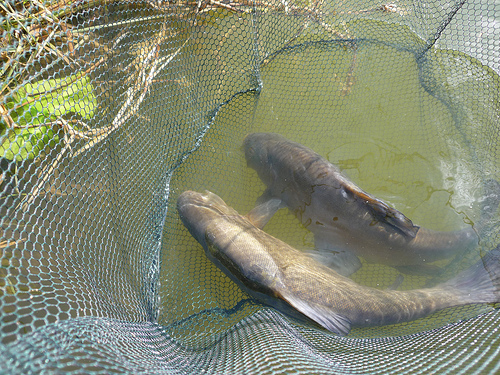

Class: n01443537 - Example image: /mnt/ssd/workspace/arcade_data/val/n01443537/ILSVRC2012_val_00000236.JPEG


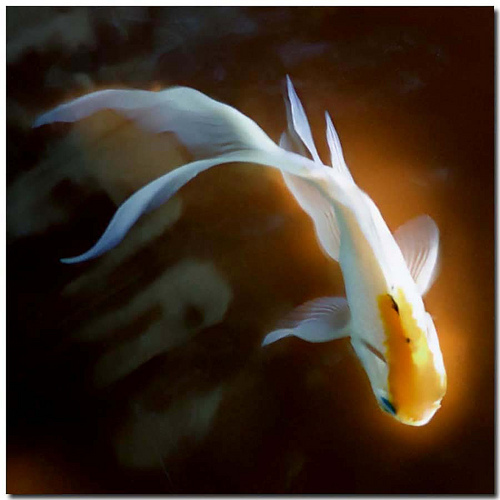

Class: n01484850 - Example image: /mnt/ssd/workspace/arcade_data/val/n01484850/ILSVRC2012_val_00002338.JPEG


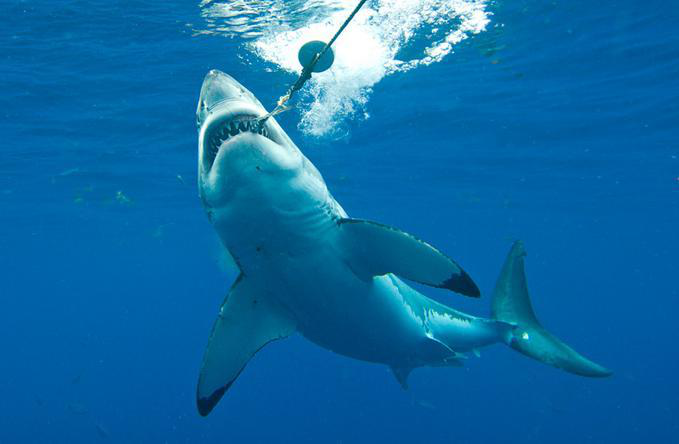

Class: n01491361 - Example image: /mnt/ssd/workspace/arcade_data/val/n01491361/ILSVRC2012_val_00002922.JPEG


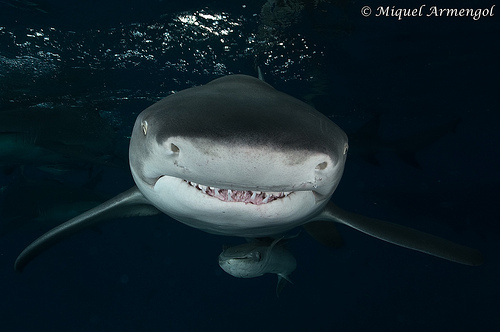

Class: n01494475 - Example image: /mnt/ssd/workspace/arcade_data/val/n01494475/ILSVRC2012_val_00001676.JPEG


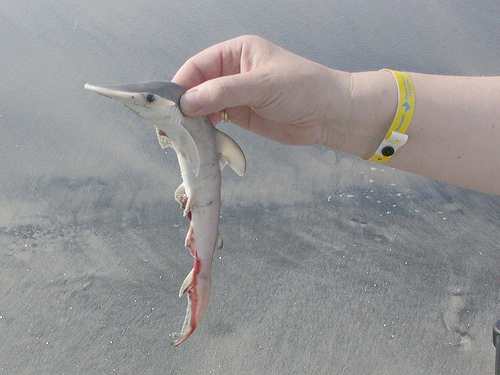

In [10]:
import os
from PIL import Image

# Path to val directory after reorg
val_dir = '/mnt/ssd/workspace/arcade_data/val'

# Pick a few classes at random
some_classes = sorted(os.listdir(val_dir))[:5]  # Just take first 5 classes, or sample if you want random

for wnid in some_classes:
    class_dir = os.path.join(val_dir, wnid)
    images = sorted([f for f in os.listdir(class_dir) if f.endswith('.JPEG')])
    if images:
        img_path = os.path.join(class_dir, images[0])
        print(f"Class: {wnid} - Example image: {img_path}")
        # Display the image (requires PIL and a Jupyter or local Python environment)
        img = Image.open(img_path)
        img.show()

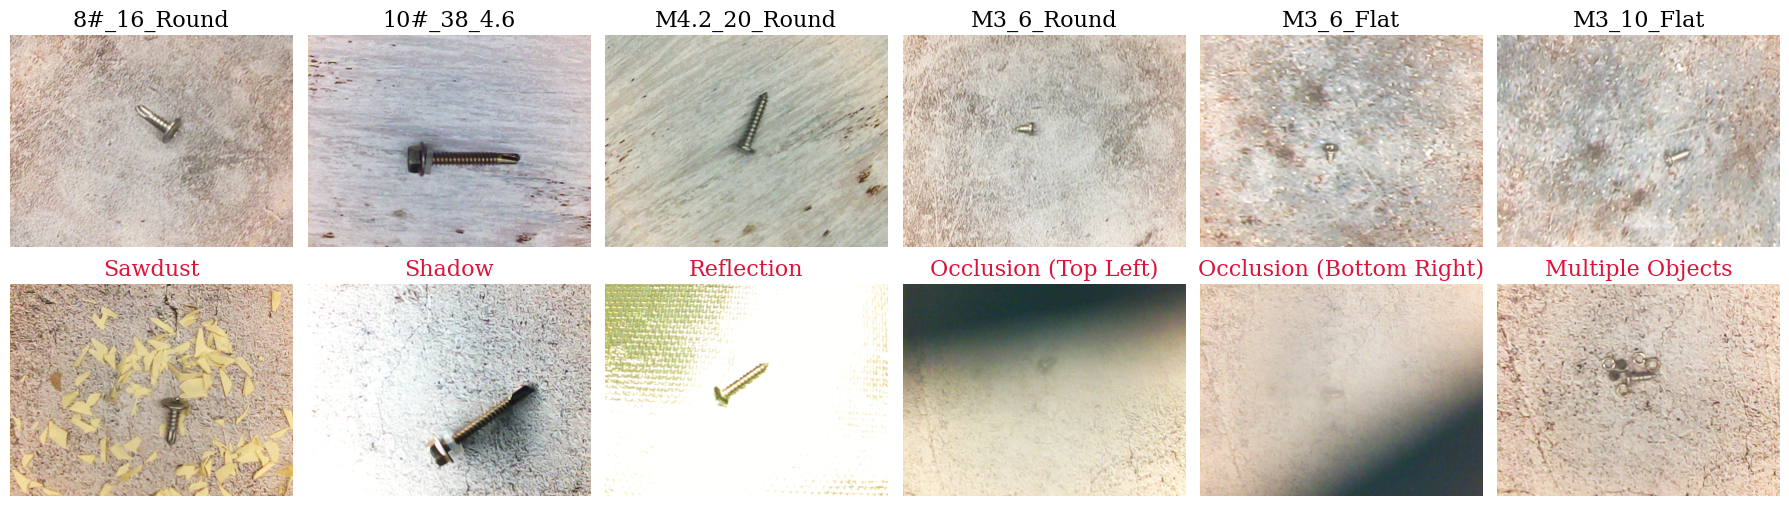

In [5]:
#!/usr/bin/env python3
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- Set AAAI-compliant font ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

random.seed(42)

CLEAN_TEST_DIR = '/root/arcade/data/screwset_split/test'
CORRUPT_ROOT = '/root/arcade/data/screwset_c'

CORRUPTION_TYPES = [
    ("Sawdust",               "screwset_scrap_paper"),
    ("Shadow",                "screwset_shadow"),
    ("Reflection",            "screwset_reflection"),
    ("Occlusion (Top Left)",  "screwset_occlusion_top_left"),
    ("Occlusion (Bottom Right)", "screwset_occlusion_bottom_right"),
    ("Multiple Objects",      "screwset_multi_object")
]

# --- SELECT 6 CLASSES FROM TEST SET ---
classes = sorted([d for d in os.listdir(CLEAN_TEST_DIR) if os.path.isdir(os.path.join(CLEAN_TEST_DIR, d))])
assert len(classes) >= 6, "Not enough classes in clean test set!"
selected_classes = random.sample(classes, 6)

# --- PICK IMAGES ---
clean_imgs = []
corrupt_imgs = []
for idx, class_name in enumerate(selected_classes):
    # Clean image (random from test set)
    class_path = os.path.join(CLEAN_TEST_DIR, class_name)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    clean_file = random.choice(files)
    clean_imgs.append((os.path.join(class_path, clean_file), class_name))

    # Corrupted image (random, same class, corresponding corruption type)
    corruption_dir = os.path.join(CORRUPT_ROOT, CORRUPTION_TYPES[idx][1])
    class_corrupt_path = os.path.join(corruption_dir, class_name)
    corrupt_files = [f for f in os.listdir(class_corrupt_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    corrupt_file = random.choice(corrupt_files)
    corrupt_imgs.append((os.path.join(class_corrupt_path, corrupt_file), CORRUPTION_TYPES[idx][0]))

# --- PLOTTING ---
fig, axs = plt.subplots(2, 6, figsize=(18, 6))
plt.subplots_adjust(top=0.92, wspace=0.2, hspace=0.1)

for i in range(6):
    # Top: clean
    img = Image.open(clean_imgs[i][0])
    axs[0, i].imshow(img)
    axs[0, i].set_title(f"{clean_imgs[i][1]}", fontsize=16)
    axs[0, i].axis('off')

    # Bottom: corrupted
    img = Image.open(corrupt_imgs[i][0])
    axs[1, i].imshow(img)
    axs[1, i].set_title(f"{corrupt_imgs[i][1]}", fontsize=16, color="crimson")
    axs[1, i].axis('off')

# Optionally, add row labels
axs[0,0].set_ylabel("Clean", fontsize=14)
axs[1,0].set_ylabel("Corrupted", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("screwset.png", dpi=300)
plt.savefig("screwset.pdf", dpi=300)
plt.show()

#### Number of images used for hessian

In [14]:
#!/usr/bin/env python3
import os

# --- CIFAR-10 (clean) ---
CIFAR10_CLEAN_DIR = '/root/arcade/data/cifar10_split/hessian_subset_test'
cifar10_clean_total = 0
if os.path.exists(CIFAR10_CLEAN_DIR):
    for cls in sorted(os.listdir(CIFAR10_CLEAN_DIR)):
        cls_path = os.path.join(CIFAR10_CLEAN_DIR, cls)
        if not os.path.isdir(cls_path):
            continue
        cifar10_clean_total += len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
else:
    print(f"[WARN] CIFAR-10 clean not found: {CIFAR10_CLEAN_DIR}")

# --- CIFAR-10-C (corrupt) ---
CIFAR10C_CORRUPTIONS = [
    "brightness", "contrast", "elastic_transform", "fog", "frost",
    "gaussian_blur", "gaussian_noise", "impulse_noise", "jpeg_compression",
    "pixelate", "saturate", "shot_noise", "snow", "spatter", "speckle_noise"
]
CIFAR10C_ROOT = '/root/arcade/data/cifar10_split'
cifar10c_total = 0
for corruption in CIFAR10C_CORRUPTIONS:
    subset_dir = os.path.join(CIFAR10C_ROOT, f'hessian_subset_{corruption}')
    if not os.path.isdir(subset_dir):
        print(f"[WARN] Not found: {subset_dir}")
        continue
    for cls in sorted(os.listdir(subset_dir)):
        cls_path = os.path.join(subset_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        cifar10c_total += len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# --- ScrewSet (clean) ---
SCREWSET_CLEAN_DIR = '/root/arcade/data/screwset_split/hessian_subset'
screwset_clean_total = 0
if os.path.exists(SCREWSET_CLEAN_DIR):
    for cls in sorted(os.listdir(SCREWSET_CLEAN_DIR)):
        cls_path = os.path.join(SCREWSET_CLEAN_DIR, cls)
        if not os.path.isdir(cls_path):
            continue
        screwset_clean_total += len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
else:
    print(f"[WARN] ScrewSet clean not found: {SCREWSET_CLEAN_DIR}")

# --- ScrewSet-C (corrupt) ---
SCREWSETC_CORRUPTIONS = [
    "hessian_subset_screwset_multi_object",
    "hessian_subset_screwset_occlusion_bottom_right",
    "hessian_subset_screwset_occlusion_top_left",
    "hessian_subset_screwset_reflection",
    "hessian_subset_screwset_scrap_paper",
    "hessian_subset_screwset_shadow",
]
SCREWSETC_ROOT = '/root/arcade/data/screwset_split/hessian_subset_corrupted'
screwsetc_total = 0
for corruption in SCREWSETC_CORRUPTIONS:
    subset_dir = os.path.join(SCREWSETC_ROOT, corruption)
    if not os.path.isdir(subset_dir):
        print(f"[WARN] Not found: {subset_dir}")
        continue
    for cls in sorted(os.listdir(subset_dir)):
        cls_path = os.path.join(subset_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        screwsetc_total += len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# --- Print Results ---
print(f"Total Hessian images (CIFAR-10 clean):      {cifar10_clean_total}")
print(f"Total Hessian images (CIFAR-10-C corrupt):  {cifar10c_total}")
print(f"Total Hessian images (ScrewSet clean):      {screwset_clean_total}")
print(f"Total Hessian images (ScrewSet-C corrupt):  {screwsetc_total}")

total = cifar10_clean_total + cifar10c_total + screwset_clean_total + screwsetc_total
print(f"Total Hessian images (ALL):                 {total}")

Total Hessian images (CIFAR-10 clean):      1000
Total Hessian images (CIFAR-10-C corrupt):  3000
Total Hessian images (ScrewSet clean):      2000
Total Hessian images (ScrewSet-C corrupt):  4800
Total Hessian images (ALL):                 10800


In [ ]:
#!/usr/bin/env python3
import sys, os
import json
import random
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
# Insert brevitas path for FP8 quantization
sys.path.insert(0, '/root/arcade/final_scripts/brevitas-master/src')


# local utilities
from utils.utils import (
    build_calib_cache,
    get_calib_loader,
    build_hessian_subset_imagefolder
)

# ---------------------- Settings ------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Calibration and Hessian subset parameters
SAMPLES_PER_CLASS = 500      # for calibration cache
HESS_SAMPLES_PER_CLASS = 50  # for Hessian subset
CALIB_DIR = '/root/arcade/data/screwset_split/train'
HESSIAN_SUBSET_DIR = '/root/arcade/data/screwset_split/hessian_subset'
CACHE_FILE = '/root/arcade/final_scripts/utils/calib_cache_screwset.npz'
SMOKE_TEST = False

# Hessian computation settings
K = 128
MAXITER = 160
Z = 1
HESS_BSZ = 64
BATCH_CALIB = 32
RUN_FP32 = True
RUN_FP8  = True

# ---------------------- Transforms ------------------------
RESIZE_DIM = (240, 320)
NORMALIZATION = {
    'mean': [0.7750, 0.7343, 0.6862],
    'std':  [0.0802, 0.0838, 0.0871]
}
test_transform = transforms.Compose([
    transforms.Resize(RESIZE_DIM),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZATION['mean'], std=NORMALIZATION['std']),
])

# ---------------------- Model Loading (Corrected) ------------------------
# ---------------------- Device Selection ------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[INFO] CUDA is available. Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("[WARNING] CUDA is not available. Using CPU. Computation may be slow.")

# 1. Create the base model
model = models.mobilenet_v3_small(weights=None)

# 2. Define the patching function
def patch_hardsigmoid_to_sigmoid(m):
    for name, child in m.named_children():
        if isinstance(child, nn.Hardsigmoid):
            setattr(m, name, nn.Sigmoid())
        else:
            patch_hardsigmoid_to_sigmoid(child)
    return m

# 3. Patch the base architecture first
model = patch_hardsigmoid_to_sigmoid(model) 

# 4. Then, adjust the final classifier layer for your dataset
in_feats = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_feats, 40)

# 5. Finally, load the weights into the fully prepared architecture
checkpoint = "/root/arcade/final_scripts/final_models/mobilenetv3_hardsigmoid_to_sigmoid_screwset_best.pth"
state = torch.load(checkpoint, map_location=device)
model.load_state_dict(state)

# 6. Move to device and set to eval mode
model = model.to(device).eval()

# ---------------------- Build Hessian Subset ------------------------
if not os.path.isdir(HESSIAN_SUBSET_DIR):
    build_hessian_subset_imagefolder(
        src_dir=os.path.join('/root/arcade/data/screwset_split/train'),
        out_dir=HESSIAN_SUBSET_DIR,
        samples_per_class=HESS_SAMPLES_PER_CLASS,
        seed=SEED
    )
# verify subset
classes = [
    d for d in sorted(os.listdir(HESSIAN_SUBSET_DIR))
    if os.path.isdir(os.path.join(HESSIAN_SUBSET_DIR, d))
]
assert len(classes) == 40, f"Expected 40 classes, found {len(classes)}: {classes}"
hessian_full = datasets.ImageFolder(HESSIAN_SUBSET_DIR, transform=test_transform)
hessian_dataset = hessian_full

if SMOKE_TEST:
    from collections import defaultdict
    counts, idxs = defaultdict(int), []
    for orig_idx, lbl in enumerate(hessian_full.targets):
        if counts[lbl] < 5:
            idxs.append(orig_idx); counts[lbl] += 1
    hessian_dataset = Subset(hessian_full, idxs)

hessian_loader = DataLoader(
    hessian_dataset,
    batch_size=HESS_BSZ,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# ---------------------- Calibration Cache ------------------------
if not os.path.exists(CACHE_FILE):
    build_calib_cache(
        calib_dir=CALIB_DIR,
        samples_per_class=SAMPLES_PER_CLASS,
        transform=test_transform,
        cache_file=CACHE_FILE,
        seed=SEED
    )
assert os.path.exists(CACHE_FILE), f"Calibration cache missing: {CACHE_FILE}"
calib_loader = get_calib_loader(
    cache_file=CACHE_FILE,
    batch_size=BATCH_CALIB
)

# ---------------------- Hessian Estimation ------------------------

def estimate_top_eigs(model, device, k=K, maxiter=MAXITER, z=Z):
    params = [p for p in model.parameters() if p.requires_grad]
    n = sum(p.numel() for p in params)

    def hvp_prod(vec):
        vec = vec.reshape(-1)
        hvp_acc = torch.zeros_like(vec, device=device)
        total_samples = 0
        for x, y in hessian_loader:
            batch_size = x.size(0)
            total_samples += batch_size
            model.zero_grad(set_to_none=True)
            x, y = x.to(device), y.to(device)
            loss = nn.functional.cross_entropy(model(x), y)
            grads1 = grad(loss, params, create_graph=True)
            grads1_flat = torch.cat([t.reshape(-1) for t in grads1])
            gTv = torch.dot(grads1_flat, vec)
            grads2 = grad(gTv, params)
            hvp_acc += batch_size * torch.cat([t.reshape(-1) for t in grads2]).detach()
        return (hvp_acc / total_samples).unsqueeze(1)

    def lanczos_with_tqdm(hvp, n, iters, device, dtype):
        q  = torch.randn(n, 1, device=device, dtype=dtype)
        q  = q / q.norm()
        beta_prev = torch.tensor(0., device=device, dtype=dtype)
        alphas, betas = [], []

        with tqdm(range(iters), desc="Lanczos", unit="iter") as bar:
            for _ in bar:
                # ---- 1.  A = Hvp(q)  ----
                Aq = hvp(q.squeeze()).squeeze()          # size [n]
                alpha = torch.dot(q.squeeze(), Aq)
                alphas.append(alpha)

                # ---- 2.  r = Aq − αq − β_prev q_prev  ----
                r = Aq - alpha * q.squeeze()
                if len(betas):
                    r -= beta_prev * q_prev.squeeze()

                beta = r.norm()
                betas.append(beta)
                if beta == 0 or torch.isnan(beta):        # convergence
                    break
                q_prev, q = q, (r / beta).unsqueeze(1)
                beta_prev = beta
        # Build tridiagonal
        T = torch.diag(torch.stack(alphas))
        for i in range(len(betas) - 1):
            T[i, i + 1] = betas[i + 1]
            T[i + 1, i] = betas[i + 1]
        return T

    T = lanczos_with_tqdm(hvp_prod, n, maxiter, params[0].device, params[0].dtype)
    eigvals = torch.linalg.eigvalsh(T)
    return eigvals.topk(k).values.cpu().numpy()

OUTPUT_DIR = "/root/arcade/final_scripts/final_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

if RUN_FP32:
    eigs32 = estimate_top_eigs(model, device, z=Z)
    np.save(os.path.join(OUTPUT_DIR, "eigs_fp32_screwset.npy"), eigs32)
    neff32 = float((eigs32 / (eigs32 + Z)).sum())
    meta32 = {"model":"mobilenetv3_screwset_fp32","dataset":"screwset","K":K,"z":Z,"neff":neff32}
    with open(os.path.join(OUTPUT_DIR,"neff_meta_fp32_screwset.json"),"w") as f:
        json.dump(meta32, f, indent=4)

if RUN_FP8:
    from brevitas.graph.quantize import preprocess_for_quantize
    from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model, calibrate, apply_bias_correction
    model_q = preprocess_for_quantize(copy.deepcopy(model),
                                      equalize_iters=20, equalize_merge_bias=True, merge_bn=True).to(device).eval()
    model_q = quantize_model(
        model_q,
        backend='fx',
        quant_format='float',
        weight_bit_width=8,
        weight_mantissa_bit_width=3,
        weight_exponent_bit_width=4,
        weight_quant_granularity='per_channel',
        weight_quant_type='sym',
        weight_param_method='stats',
        act_bit_width=8,
        act_mantissa_bit_width=3,
        act_exponent_bit_width=4,
        act_quant_granularity='per_tensor',
        act_quant_percentile=99.999,
        act_quant_type='sym',
        act_param_method='stats',
        act_scale_computation_type='static',
        scale_factor_type='float_scale', 
        bias_bit_width=None, 
        device=device
    ).to(device).eval()
    with torch.no_grad():
        calibrate(calib_loader, model_q)
        apply_bias_correction(calib_loader, model_q)
    eigs8 = estimate_top_eigs(model_q, device, z=Z)
    np.save(os.path.join(OUTPUT_DIR,"eigs_fp8_e4m3_screwset.npy"), eigs8)
    neff8 = float((eigs8 / (eigs8 + Z)).sum())
    meta8 = {"model":"mobilenetv3_screwset_fp8_e4m3","dataset":"screwset","K":K,"z":Z,"neff":neff8}
    with open(os.path.join(OUTPUT_DIR,"neff_meta_fp8_e4m3_screwset.json"),"w") as f:
        json.dump(meta8, f, indent=4)

#2nd PIECE
import numpy as np
import os
import json
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit

# -------- SETTINGS --------
RESULTS_DIR = "/root/arcade/final_scripts/final_results/hessians/screwset"
ACC_JSON = "/root/arcade/final_scripts/final_results/quant_results_matrix_screwset.json"
CLEAN_FP32 = "eigs_fp32_screwset.npy"
CLEAN_FP8  = "eigs_fp8_e4m3_screwset.npy"
FP32_PREFIX = "eigs_fp32_screwset_hessian_subset"
FP8_PREFIX = "eigs_fp8_e4m3_screwset_hessian_subset"
Z_EFFDIM = 1
CORRUPTIONS = [
    "clean",
    "screwset_multi_object",
    "screwset_occlusion_bottom_right",
    "screwset_occlusion_top_left",
    "screwset_reflection",
    "screwset_scrap_paper",
    "screwset_shadow"
]

# -------- LOAD ACCURACIES FROM JSON --------
def get_acc_dicts(json_path, replacement="hardsigmoid_to_sigmoid"):
    with open(json_path, "r") as f:
        all_res = json.load(f)
    acc_map_fp32 = {}
    acc_map_fp8 = {}
    for res in all_res:
        if res["replacement"] == replacement and res["quant_type"] == "FP32":
            acc_map_fp32["clean"] = res["clean_accuracy"]
            acc_map_fp32.update(res["corrupt_accuracy_per_type"])
        if res["replacement"] == replacement and res["quant_type"] == "PTQ" and \
           res.get("quant_config", {}).get("name") == "PTQ_FP8_E4M3":
            acc_map_fp8["clean"] = res["clean_accuracy"]
            acc_map_fp8.update(res["corrupt_accuracy_per_type"])
    return acc_map_fp32, acc_map_fp8

acc_map_fp32, acc_map_fp8 = get_acc_dicts(ACC_JSON)

# -------- METRIC FUNCTIONS --------
def metrics(eigs, z=Z_EFFDIM):
    eigs = np.sort(eigs)[::-1]
    eigsum = eigs.sum()
    trace = eigsum
    l1 = eigs[0]
    head10 = eigs[:10].sum() / eigsum
    tail = eigs[10:].sum() / eigsum
    pr = (eigsum**2) / (np.square(eigs).sum())
    p = eigs / eigsum
    # --- Robust spectral entropy ---
    if np.all(p == 0) or np.isnan(p).any():
        spectral_entropy = np.nan
    else:
        p_nonzero = p[p > 0]
        spectral_entropy = -np.sum(p_nonzero * np.log(p_nonzero))
    kappa = eigs[0] / eigs[-1]
    neff = (eigs / (eigs + z)).sum()
    return dict(
        trace=trace,
        largest_eig=l1,
        head10=head10,
        tail=tail,
        pr=pr,
        spectral_entropy=spectral_entropy,
        kappa=kappa,
        neff=neff
    )

def power_law_alpha(eigs):
    eigs = np.sort(eigs)[::-1]
    x = np.arange(1, len(eigs) + 1)
    y = eigs
    mask = y > 0
    logx = np.log(x[mask])
    logy = np.log(y[mask])
    def lin(x, a, b): return a * x + b
    a, _ = curve_fit(lin, logx, logy)[0]
    return -a

# -------- MAIN: COLLECT METRICS --------
results = []
for corr in CORRUPTIONS:
    if corr == "clean":
        fp32_path = os.path.join(RESULTS_DIR, CLEAN_FP32)
        fp8_path = os.path.join(RESULTS_DIR, CLEAN_FP8)
    else:
        fp32_path = os.path.join(RESULTS_DIR, f"{FP32_PREFIX}_{corr}.npy")
        fp8_path  = os.path.join(RESULTS_DIR, f"{FP8_PREFIX}_{corr}.npy")
    if not (os.path.exists(fp32_path) and os.path.exists(fp8_path)):
        print(f"Skipping {corr}: missing file(s): {fp32_path}, {fp8_path}")
        continue
    eigs_fp32 = np.load(fp32_path)
    eigs_fp8 = np.load(fp8_path)

    m_fp32 = metrics(eigs_fp32, Z_EFFDIM)
    m_fp8 = metrics(eigs_fp8, Z_EFFDIM)
    delta = {k: m_fp8[k] - m_fp32[k] for k in m_fp32}
    try:
        alpha_fp32 = power_law_alpha(eigs_fp32)
        alpha_fp8 = power_law_alpha(eigs_fp8)
        delta['alpha'] = alpha_fp8 - alpha_fp32
    except Exception:
        alpha_fp32 = alpha_fp8 = np.nan

    acc_fp32 = acc_map_fp32.get(corr, np.nan)
    acc_fp8 = acc_map_fp8.get(corr, np.nan)
    delta_acc = acc_fp8 - acc_fp32

    results.append({
        'corruption': corr,
        'fp32': m_fp32,
        'fp8': m_fp8,
        'delta': delta,
        'acc_fp32': acc_fp32,
        'acc_fp8': acc_fp8,
        'delta_acc': delta_acc,
        'alpha_fp32': alpha_fp32,
        'alpha_fp8': alpha_fp8
    })

# -------- SUMMARY TABLE --------
summary = []
for r in results:
    s = {'corruption': r['corruption'], 'ΔAccuracy': r['delta_acc']}
    for k in r['delta']:
        s[f'Δ{k}'] = r['delta'][k]
    summary.append(s)
df = pd.DataFrame(summary)
print(df.round(5))

# -------- CORRELATIONS --------
metrics_of_interest = ['Δtrace', 'Δneff', 'Δpr', 'Δhead10', 'Δtail', 'Δalpha']
for m in metrics_of_interest:
    if m in df.columns:
        vals = df[m].values
        corr_spear, _ = spearmanr(vals, df['ΔAccuracy'])
        corr_pear, _ = pearsonr(vals, df['ΔAccuracy'])
        print(f"{m} vs ΔAccuracy: Spearman={corr_spear:.3f}, Pearson={corr_pear:.3f}")

# -------- SAVE TO CSV --------
csv_path = os.path.join(RESULTS_DIR, "spectrum_metrics_delta_summary_screwset.csv")
df.to_csv(csv_path, index=False)
print(f"Saved CSV to: {csv_path}")

#3th Piece
#!/usr/bin/env python3
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import pearsonr, spearmanr
from pathlib import Path

# ---------------------------------------------------------------- paths ----
ROOT = Path("/root/arcade/final_scripts/final_results/hessians")
CSV = {
    "ScrewSet-C" : ROOT / "screwset" / "spectrum_metrics_delta_summary_screwset.csv",
    "CIFAR-10-C": ROOT / "cifar10"  / "spectrum_metrics_delta_summary_cifar10.csv",
}
OUT_DIR = ROOT          # change if you prefer another folder
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ---------------------------------------------------------- correlations ----
def corr_table(df):
    rows = []
    for col in df.filter(regex=r"^Δ").columns:
        if col == "ΔAccuracy": continue
        x, y = df[col], df["ΔAccuracy"]
        mask = x.notna() & y.notna()
        if mask.sum() < 3: continue
        rows.append({
            "metric"   : col,
            "Pearson"  : pearsonr(x[mask],  y[mask])[0],
            "Spearman" : spearmanr(x[mask], y[mask])[0],
        })
    return (pd.DataFrame(rows)
              .set_index("metric")
              .sort_values("Spearman"))

all_tables = []
for name, path in CSV.items():
    tb = corr_table(pd.read_csv(path))
    print(f"\n{name}\n{tb.round(3)}")
    tb.to_csv(OUT_DIR / f"corr_table_{name}.csv")
    tb["dataset"] = name
    all_tables.append(tb.reset_index())

# combined CSV (optional)
pd.concat(all_tables, ignore_index=True).to_csv(OUT_DIR / "corr_table_combined.csv", index=False)

# ----------------------------------------- scatter figure ----
metrics = ["Δpr", "Δtrace", "Δlargest_eig", "Δneff"]
fig, axes = plt.subplots(len(metrics), len(CSV), figsize=(11, 3*len(metrics)))
for r, m in enumerate(metrics):
    for c, (name, path) in enumerate(CSV.items()):
        df = pd.read_csv(path)
        ax = axes[r, c] if len(metrics) > 1 else axes[c]
        sns.regplot(data=df, x=m, y="ΔAccuracy",
                    ax=ax, scatter_kws=dict(s=40), line_kws=dict(ls="--"))
        ax.set_title(f"{name}: {m} vs ΔAcc")
        ax.axhline(0, c="grey", lw=.8); ax.axvline(0, c="grey", lw=.8)
fig.tight_layout()
fig.savefig(OUT_DIR / "correlation_scatter.png", dpi=300)
print(f"\nSaved correlation tables and scatter figure to {OUT_DIR}")


In [16]:
import os

def count_images_per_class(root):
    results = {}
    for cls in sorted(os.listdir(root)):
        cls_dir = os.path.join(root, cls)
        if os.path.isdir(cls_dir):
            count = len([f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))])
            results[cls] = count
    return results

train_dir = '/root/arcade/data/cifar10_split/hessian_subset_train'
test_dir = '/root/arcade/data/cifar10_split/hessian_subset_test'

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

print("Class\tTrain\tTest")
for cls in sorted(set(train_counts) | set(test_counts)):
    print(f"{cls}\t{train_counts.get(cls, 0)}\t{test_counts.get(cls, 0)}")

Class	Train	Test
airplane	100	100
automobile	100	100
bird	100	100
cat	100	100
deer	100	100
dog	100	100
frog	100	100
horse	100	100
ship	100	100
truck	100	100


In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Tiny dataset: 4 samples, 2 classes
X = torch.randn(4, 3, 32, 32)
y = torch.tensor([0, 1, 0, 1])

tiny_dataset = TensorDataset(X, y)
tiny_loader = DataLoader(tiny_dataset, batch_size=2)

# Tiny model: 3x32x32 -> 2 classes
class TinyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 32 * 32, 2)
    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

tiny_model = TinyModel()

def test_estimate_top_eigs(model, loader):
    params = [p for p in model.parameters() if p.requires_grad]
    n = sum(p.numel() for p in params)
    def hess_vec_prod(vec):
        # Accepts (n,) or (n, k)
        if vec.ndim == 2:
            return torch.stack([hess_vec_prod(v) for v in vec.t()], dim=1)
        vec = vec.reshape(-1)
        hvp_acc = torch.zeros_like(vec)
        total_samples = 0
        for x, y in loader:
            model.zero_grad(set_to_none=True)
            batch_size = x.size(0)
            total_samples += batch_size
            loss = nn.functional.cross_entropy(model(x), y)
            grads1 = torch.autograd.grad(loss, params, create_graph=True)
            g = torch.cat([t.reshape(-1) for t in grads1])
            gTv = torch.dot(g, vec)
            grads2 = torch.autograd.grad(gTv, params)
            hvp_acc += batch_size * torch.cat([t.reshape(-1) for t in grads2]).detach()
            del grads1, g, gTv, grads2
        hvp_avg = hvp_acc / total_samples
        return hvp_avg  # (n,)
    from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag
    eigvals, _ = lanczos_tridiag_to_diag(
        lanczos_tridiag(
            hess_vec_prod,
            2,
            torch.float32,
            'cpu',
            (n, n)
        )[1]  # <-- this is the fix
    )
    topk = eigvals.topk(2).values
    print("Top eigenvalues:", topk)

test_estimate_top_eigs(tiny_model, tiny_loader)

Top eigenvalues: tensor([3.6738e+02, 3.6573e-04])


FP32 Eigenvalues:
 [1.9587267e+03 7.9390863e+02 5.4754486e+02 4.5057990e+02 3.9274887e+02
 2.6926544e+02 2.5143794e+02 2.2553708e+02 2.0472964e+02 1.9218686e+02
 1.5528281e+02 1.3713622e+02 1.1559811e+02 1.0784841e+02 9.3890289e+01
 9.0884956e+01 8.4232590e+01 7.8190468e+01 7.3995049e+01 6.7278473e+01
 6.2069408e+01 5.9924866e+01 5.8891861e+01 5.6239902e+01 5.4056393e+01
 5.1582317e+01 5.0143452e+01 4.7913486e+01 4.7079731e+01 4.5830509e+01
 4.3603294e+01 4.1178780e+01 3.9221901e+01 3.8223953e+01 3.6955570e+01
 3.5845173e+01 3.5227509e+01 3.4250927e+01 3.2163048e+01 3.0898958e+01
 3.0627863e+01 2.9409689e+01 2.8851259e+01 2.7407766e+01 2.6499758e+01
 2.6092566e+01 2.5472956e+01 2.5179995e+01 2.4347679e+01 2.4027224e+01
 2.2903227e+01 2.2611589e+01 2.2422977e+01 2.2027979e+01 2.1451799e+01
 2.0776400e+01 2.0659246e+01 2.0097092e+01 1.9594118e+01 1.9360067e+01
 1.8574587e+01 1.8340269e+01 1.8031168e+01 1.7938896e+01 1.7681765e+01
 1.7269197e+01 1.7201965e+01 1.6728481e+01 1.6454264e+01 1

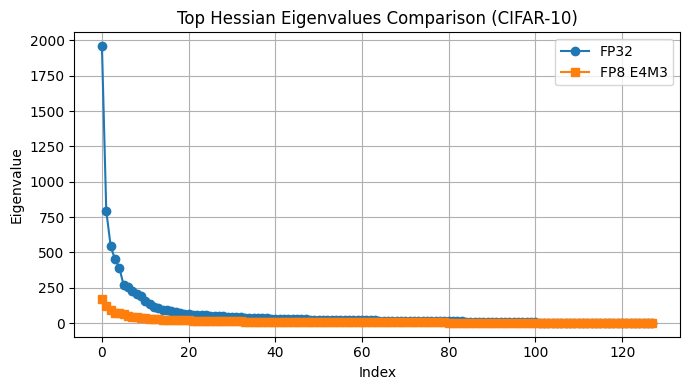

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fp8_path = '/root/arcade/final_scripts/final_results/cifar-10-results/eigs_fp8_e4m3_cifar10.npy'
fp32_path = '/root/arcade/final_scripts/final_results/cifar-10-results/eigs_fp32_cifar10.npy'

eigs_fp8 = np.load(fp8_path)
eigs_fp32 = np.load(fp32_path)

# Sort descending
eigs_fp8_sorted = np.sort(eigs_fp8)[::-1]
eigs_fp32_sorted = np.sort(eigs_fp32)[::-1]

print("FP32 Eigenvalues:\n", eigs_fp32_sorted)
print("\nFP8 E4M3 Eigenvalues:\n", eigs_fp8_sorted)

plt.figure(figsize=(7, 4))
plt.plot(eigs_fp32_sorted, 'o-', label='FP32')
plt.plot(eigs_fp8_sorted, 's-', label='FP8 E4M3')
plt.title('Top Hessian Eigenvalues Comparison (CIFAR-10)')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

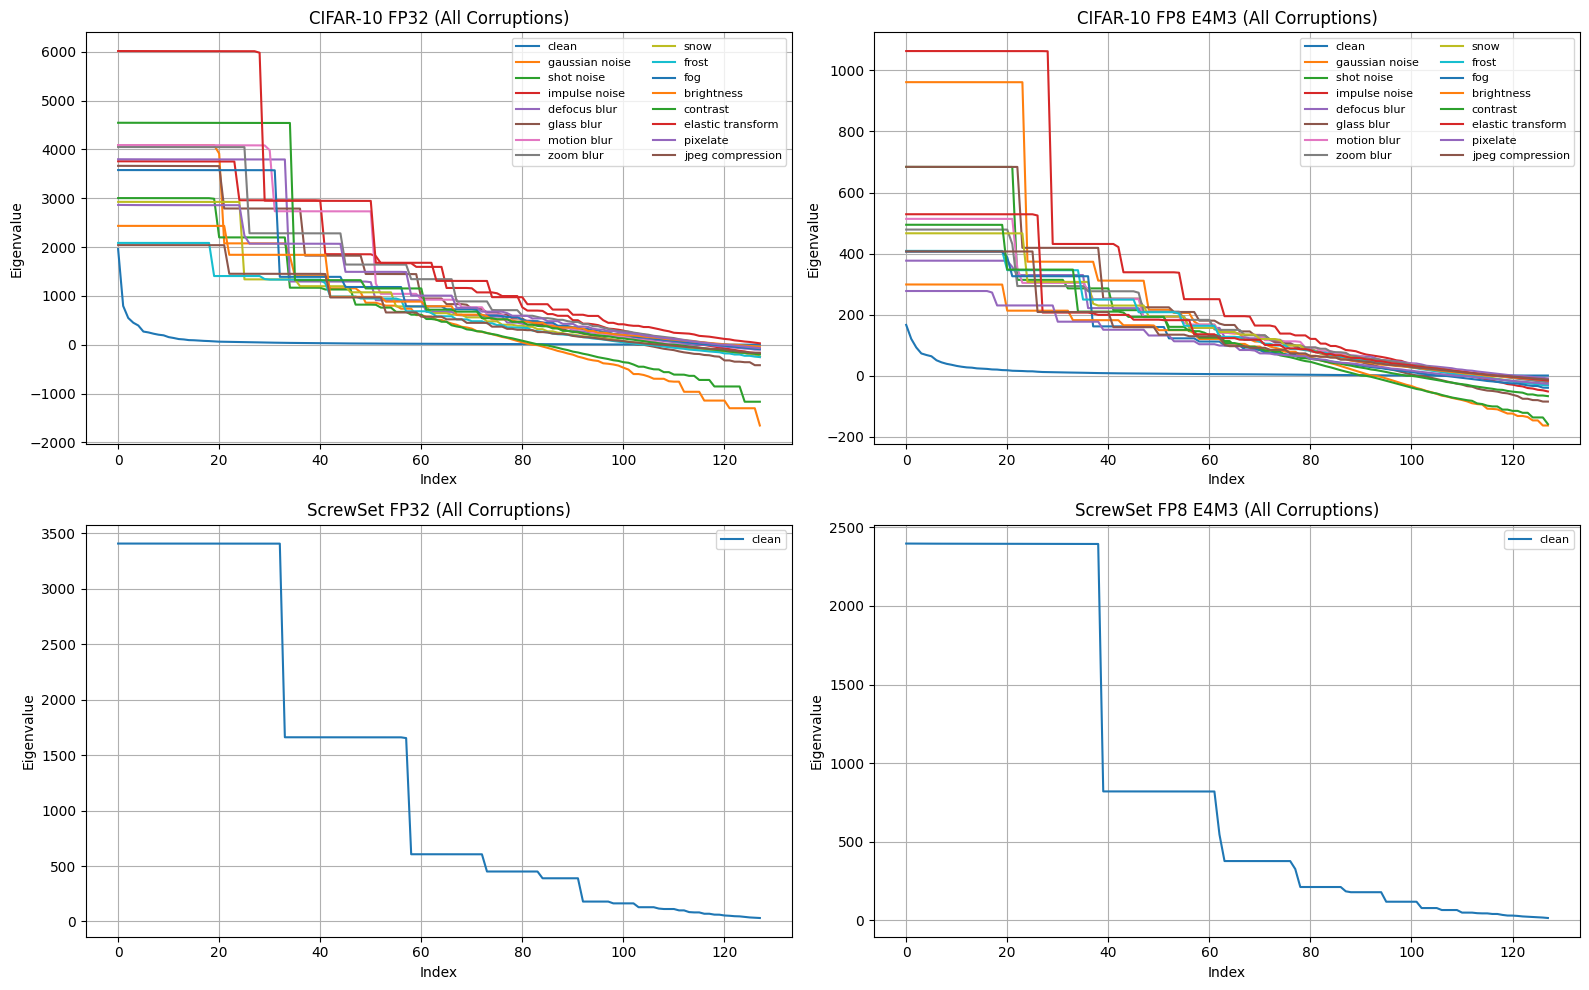

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Config ---
output_dir_cifar = '/root/arcade/final_scripts/final_results/cifar-10-results'
output_dir_screwset = '/root/arcade/final_scripts/final_results/screwset-results'

corruptions = [
    "clean",  # manually add clean
    "gaussian_noise", "shot_noise", "impulse_noise",
    "defocus_blur", "glass_blur", "motion_blur", "zoom_blur",
    "snow", "frost", "fog", "brightness", "contrast",
    "elastic_transform", "pixelate", "jpeg_compression"
]
screwset_corruptions = [
    "clean",  # handled below
    "multi_object", "occlusion_bottom_right", "occlusion_top_left",
    "reflection", "scrap_paper", "shadow"
]

# --- Helper functions ---
def file_for_cifar(fp_type, corr):
    if corr == "clean":
        return os.path.join(output_dir_cifar, f"eigs_{fp_type}_cifar10.npy")
    else:
        return os.path.join(output_dir_cifar, f"eigs_{fp_type}_{corr}.npy")

def file_for_screwset(fp_type, corr):
    if corr == "clean":
        return os.path.join(output_dir_screwset, f"eigs_{fp_type}_screwset.npy")
    else:
        return os.path.join(output_dir_screwset, f"eigs_{fp_type}_screwset_{corr}.npy")

# --- Gather all eigenvalues ---
def gather_eigs(corrs, file_fn, fp_type):
    eigs_dict = {}
    for corr in corrs:
        f = file_fn(fp_type, corr)
        if os.path.exists(f):
            eigs_dict[corr] = np.sort(np.load(f))[::-1]
        else:
            print(f"Warning: {f} not found")
    return eigs_dict

eigs_cifar_fp32 = gather_eigs(corruptions, file_for_cifar, "fp32")
eigs_cifar_fp8  = gather_eigs(corruptions, file_for_cifar, "fp8_e4m3")
eigs_screw_fp32 = gather_eigs(screwset_corruptions, file_for_screwset, "fp32")
eigs_screw_fp8  = gather_eigs(screwset_corruptions, file_for_screwset, "fp8_e4m3")

# --- Plot all 4 figures ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# CIFAR-10 FP32
for corr, eigvals in eigs_cifar_fp32.items():
    axs[0,0].plot(eigvals, label=corr.replace('_',' '))
axs[0,0].set_title('CIFAR-10 FP32 (All Corruptions)')
axs[0,0].set_xlabel('Index')
axs[0,0].set_ylabel('Eigenvalue')
axs[0,0].legend(ncol=2, fontsize=8)
axs[0,0].grid(True)

# CIFAR-10 FP8
for corr, eigvals in eigs_cifar_fp8.items():
    axs[0,1].plot(eigvals, label=corr.replace('_',' '))
axs[0,1].set_title('CIFAR-10 FP8 E4M3 (All Corruptions)')
axs[0,1].set_xlabel('Index')
axs[0,1].set_ylabel('Eigenvalue')
axs[0,1].legend(ncol=2, fontsize=8)
axs[0,1].grid(True)

# ScrewSet FP32
for corr, eigvals in eigs_screw_fp32.items():
    axs[1,0].plot(eigvals, label=corr.replace('_',' '))
axs[1,0].set_title('ScrewSet FP32 (All Corruptions)')
axs[1,0].set_xlabel('Index')
axs[1,0].set_ylabel('Eigenvalue')
axs[1,0].legend(ncol=2, fontsize=8)
axs[1,0].grid(True)

# ScrewSet FP8
for corr, eigvals in eigs_screw_fp8.items():
    axs[1,1].plot(eigvals, label=corr.replace('_',' '))
axs[1,1].set_title('ScrewSet FP8 E4M3 (All Corruptions)')
axs[1,1].set_xlabel('Index')
axs[1,1].set_ylabel('Eigenvalue')
axs[1,1].legend(ncol=2, fontsize=8)
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

#### EXAMPLE HESSIAN TEST

In [1]:
import torch
import torch.nn as nn
from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag

# Tiny linear model, no bias, 2 params
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor([3.0, 4.0]))
    def forward(self, x):
        return (self.w * x).sum(dim=1, keepdim=True)

net = TinyNet()
x = torch.tensor([[1.0, 2.0]])
def criterion(pred): return (pred**2).mean()

def hvp_regularized(net, x, v, epsilon=1e-6):
    net.zero_grad()
    y = net(x)
    loss = criterion(y)
    grad_w = torch.autograd.grad(loss, net.parameters(), create_graph=True)[0]
    prod = torch.dot(grad_w, v)
    Hv = torch.autograd.grad(prod, net.parameters(), retain_graph=True)[0]
    return Hv + epsilon * v  # Regularization for stability

def hvp_wrapper(vecs):
    epsilon = 1e-6  # Chosen regularization value for large models
    outs = []
    for i in range(vecs.shape[1]):
        out = hvp_regularized(net, x, vecs[:, i], epsilon)
        outs.append(out)
    return torch.stack(outs, dim=1)

# Estimate eigenvalues using Lanczos (regularized)
N = 2
q, t = lanczos_tridiag(
    hvp_wrapper,
    max_iter=2,
    dtype=torch.float32,
    device='cpu',
    matrix_shape=(N, N)
)
eigvals, eigvecs = lanczos_tridiag_to_diag(t)
eigvals = torch.sort(eigvals).values

# Set z to the weight decay used during training (as recommended)
z = 1e-4  # Change to your actual weight decay if different
print(f"\nChosen z (should match weight decay): {z}\n")

print("Lanczos eigenvalues (regularized):")
for i, ev in enumerate(eigvals):
    print(f"  Eigenvalue {i}: {ev.item():.6f}")

def effective_dim(eigvals, z):
    return float(torch.sum(eigvals / (eigvals + z)))

eff_dim_est = effective_dim(eigvals, z)
print(f"\nEffective dimensionality (Regularized Lanczos eigvals, z={z}): {eff_dim_est:.5f}")

# Direct Hessian (unregularized, for comparison)
H = torch.tensor([[2., 4.],[4., 8.]])
eigvals_full = torch.linalg.eigvalsh(H)
print("\nDirect eigenvalues:")
for i, ev in enumerate(eigvals_full):
    print(f"  Eigenvalue {i}: {ev.item():.6f}")

eff_dim_full = effective_dim(eigvals_full, z)
print(f"\nEffective dimensionality (Full eigvals, z={z}): {eff_dim_full:.5f}")


Chosen z (should match weight decay): 0.0001

Lanczos eigenvalues (regularized):
  Eigenvalue 0: 0.000001
  Eigenvalue 1: 10.000000

Effective dimensionality (Regularized Lanczos eigvals, z=0.0001): 1.00914

Direct eigenvalues:
  Eigenvalue 0: 0.000000
  Eigenvalue 1: 10.000000

Effective dimensionality (Full eigvals, z=0.0001): 0.99999


In [5]:
import numpy as np
import json
import pandas as pd

# --- Settings ---
fp32_path = '/root/arcade/final_scripts/final_results/cifar-10-results/eigs_fp32_cifar10.npy'
fp8_path =  '/root/arcade/final_scripts/final_results/cifar-10-results/eigs_fp8_e4m3_cifar10.npy'
acc_json = '/root/arcade/final_scripts/final_results/quant_results_matrix_cifar10.json'
z = 1e-4

# --- Metric Calculations ---
def metrics(eigs, z):
    eigs = np.sort(eigs)[::-1]
    eigsum = eigs.sum()
    pr = (eigsum ** 2) / (np.square(eigs).sum())
    l1 = eigs[0]
    head10 = eigs[:10].sum() / eigsum
    tail = eigs[10:].sum() / eigsum
    p = eigs / eigsum
    p_nonzero = p[p > 0]
    spectral_entropy = -np.sum(p_nonzero * np.log(p_nonzero)) if len(p_nonzero) else np.nan
    kappa = eigs[0] / eigs[-1] if eigs[-1] != 0 else np.nan
    neff = (eigs / (eigs + z)).sum()
    return {
        "trace": eigsum,
        "largest_eig": l1,
        "head10": head10,
        "tail": tail,
        "pr": pr,
        "spectral_entropy": spectral_entropy,
        "kappa": kappa,
        "neff": neff,
    }

def power_law_alpha(eigs):
    eigs = np.sort(eigs)[::-1]
    x = np.arange(1, len(eigs)+1)
    y = eigs
    mask = y > 0
    if mask.sum() < 2:
        return np.nan
    logx = np.log(x[mask])
    logy = np.log(y[mask])
    a, _ = np.polyfit(logx, logy, 1)
    return -a

# --- Load accuracy from JSON ---
with open(acc_json, "r") as f:
    all_results = json.load(f)
def get_acc_map(res_list, quant_type, replacement="hardsigmoid_to_sigmoid"):
    for res in res_list:
        if res["replacement"] == replacement and res["quant_type"] == quant_type:
            acc_map = {"clean": res["clean_accuracy"]}
            acc_map.update(res["corrupt_accuracy_per_type"])
            return acc_map
    return None
acc_fp32 = get_acc_map(all_results, "FP32")
acc_fp8  = get_acc_map(all_results, "PTQ")
assert acc_fp32 and acc_fp8, "Did not find accuracies for both FP32 and FP8."

# --- Load eigenvalues and compute metrics ---
eigs_fp32 = np.load(fp32_path)
eigs_fp8  = np.load(fp8_path)
m_fp32 = metrics(eigs_fp32, z)
m_fp8  = metrics(eigs_fp8, z)
delta = {k: m_fp8[k] - m_fp32[k] for k in m_fp32}
alpha_fp32 = power_law_alpha(eigs_fp32)
alpha_fp8 = power_law_alpha(eigs_fp8)
delta_alpha = alpha_fp8 - alpha_fp32

row = {
    "corruption": "clean",
    "acc_fp32": acc_fp32["clean"],
    "acc_fp8": acc_fp8["clean"],
    "delta_acc": acc_fp8["clean"] - acc_fp32["clean"],
    "alpha_fp32": alpha_fp32,
    "alpha_fp8": alpha_fp8,
    "delta_alpha": delta_alpha,
}
for k in m_fp32:
    row[f"fp32_{k}"] = m_fp32[k]
    row[f"fp8_{k}"] = m_fp8[k]
    row[f"delta_{k}"] = delta[k]

df = pd.DataFrame([row])
print(df.T)

                                  0
corruption                    clean
acc_fp32                     0.7825
acc_fp8                       0.769
delta_acc                   -0.0135
alpha_fp32                 1.636778
alpha_fp8                  1.278027
delta_alpha               -0.358751
fp32_trace              8198.500977
fp8_trace               1566.674072
delta_trace            -6631.827148
fp32_largest_eig        1958.726685
fp8_largest_eig          166.746643
delta_largest_eig       -1791.97998
fp32_head10                0.644833
fp8_head10                 0.483131
delta_head10              -0.161702
fp32_tail                  0.355167
fp8_tail                   0.516869
delta_tail                 0.161702
fp32_pr                    12.09237
fp8_pr                    29.285413
delta_pr                  17.193043
fp32_spectral_entropy      3.421598
fp8_spectral_entropy       3.991597
delta_spectral_entropy     0.569998
fp32_kappa              1958.726685
fp8_kappa                166

In [1]:
import os

CORRUPT_DIR = "/mnt/ssd/workspace/arcade_data/corruptions"

corruption_types = [
    d for d in sorted(os.listdir(CORRUPT_DIR))
    if os.path.isdir(os.path.join(CORRUPT_DIR, d))
]

print(f"Total corruption types: {len(corruption_types)}\n")

for ctype in corruption_types:
    ctype_dir = os.path.join(CORRUPT_DIR, ctype)
    severities = [
        s for s in sorted(os.listdir(ctype_dir))
        if os.path.isdir(os.path.join(ctype_dir, s))
    ]
    print(f"{ctype}: {len(severities)} severity levels (folders: {', '.join(severities)})")

Total corruption types: 15

brightness: 5 severity levels (folders: 1, 2, 3, 4, 5)
contrast: 5 severity levels (folders: 1, 2, 3, 4, 5)
elastic_transform: 5 severity levels (folders: 1, 2, 3, 4, 5)
fog: 5 severity levels (folders: 1, 2, 3, 4, 5)
frost: 5 severity levels (folders: 1, 2, 3, 4, 5)
gaussian_blur: 5 severity levels (folders: 1, 2, 3, 4, 5)
gaussian_noise: 5 severity levels (folders: 1, 2, 3, 4, 5)
impulse_noise: 5 severity levels (folders: 1, 2, 3, 4, 5)
jpeg_compression: 5 severity levels (folders: 1, 2, 3, 4, 5)
pixelate: 5 severity levels (folders: 1, 2, 3, 4, 5)
saturate: 5 severity levels (folders: 1, 2, 3, 4, 5)
shot_noise: 5 severity levels (folders: 1, 2, 3, 4, 5)
snow: 5 severity levels (folders: 1, 2, 3, 4, 5)
spatter: 5 severity levels (folders: 1, 2, 3, 4, 5)
speckle_noise: 5 severity levels (folders: 1, 2, 3, 4, 5)


In [2]:
import os

IMAGENETA_DIR = '/mnt/ssd/workspace/arcade_data/imagenet-a'

total_img_a = 0
for root, dirs, files in os.walk(IMAGENETA_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            total_img_a += 1

print(f"ImageNet-A total images: {total_img_a}")

ImageNet-A total images: 7500


In [3]:
import os

SUBSET_DIR = '/mnt/ssd/workspace/arcade_data/hessian_subset_train_imagenet'

total_subset = 0
for root, dirs, files in os.walk(SUBSET_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            total_subset += 1

print(f"Total images in Hessian subset: {total_subset}")

Total images in Hessian subset: 4000


In [4]:
import os
import random
import shutil

CORRUPT_DIR = '/mnt/ssd/workspace/arcade_data/corruptions'
OUT_DIR = '/mnt/ssd/workspace/arcade_data/hessian_subset_corruptions'
os.makedirs(OUT_DIR, exist_ok=True)

corrupt_types = sorted([d for d in os.listdir(CORRUPT_DIR) if os.path.isdir(os.path.join(CORRUPT_DIR, d))])
n_severities = 5
images_per_pair = 53  # 4000 // 75

all_selected = 0

for ctype in corrupt_types:
    for severity in range(1, n_severities+1):
        src = os.path.join(CORRUPT_DIR, ctype, str(severity))
        if not os.path.isdir(src):
            print(f"Missing: {src}")
            continue
        imgs = [f for f in os.listdir(src) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(imgs) < images_per_pair:
            print(f"Not enough images in {src}, only {len(imgs)}")
            continue
        chosen = random.sample(imgs, images_per_pair)
        outdir = os.path.join(OUT_DIR, f"{ctype}_s{severity}")
        os.makedirs(outdir, exist_ok=True)
        for img in chosen:
            shutil.copy2(os.path.join(src, img), os.path.join(outdir, img))
        all_selected += len(chosen)
        print(f"{ctype} severity {severity}: selected {len(chosen)} images")
        
print(f"Total selected: {all_selected}")

Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/brightness/1, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/brightness/2, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/brightness/3, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/brightness/4, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/brightness/5, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/contrast/1, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/contrast/2, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/contrast/3, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/contrast/4, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/contrast/5, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/elastic_transform/1, only 0
Not enough images in /mnt/ssd/workspace/arcade_data/corruptions/elas

In [6]:
import os

def count_images_in_dir(directory, exts=(".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(exts):
                count += 1
    return count

# Directories to count
dirs_to_count = [
    "/root/arcade/data/screwset_split/hessian_subset",
    "/root/arcade/data/screwset_split/hessian_subset_corrupted",
    "/root/arcade/data/cifar10_split/hessian_subset_train"
]

# Add all hessian_subset_* folders in cifar10_split except train/test/validation
cifar10_dir = "/root/arcade/data/cifar10_split"
for name in os.listdir(cifar10_dir):
    path = os.path.join(cifar10_dir, name)
    if (
        name.startswith("hessian_subset_")
        and name not in {"hessian_subset_train", "hessian_subset_test", "hessian_subset_validation"}
        and os.path.isdir(path)
    ):
        dirs_to_count.append(path)

# Count and print results
for d in dirs_to_count:
    print(f"{d}: {count_images_in_dir(d)} images")

/root/arcade/data/screwset_split/hessian_subset: 2000 images
/root/arcade/data/screwset_split/hessian_subset_corrupted: 4800 images
/root/arcade/data/cifar10_split/hessian_subset_train: 1000 images
/root/arcade/data/cifar10_split/hessian_subset_impulse_noise: 200 images
/root/arcade/data/cifar10_split/hessian_subset_saturate: 200 images
/root/arcade/data/cifar10_split/hessian_subset_gaussian_noise: 200 images
/root/arcade/data/cifar10_split/hessian_subset_contrast: 200 images
/root/arcade/data/cifar10_split/hessian_subset_motion_blur: 200 images
/root/arcade/data/cifar10_split/hessian_subset_pixelate: 200 images
/root/arcade/data/cifar10_split/hessian_subset_zoom_blur: 200 images
/root/arcade/data/cifar10_split/hessian_subset_fog: 200 images
/root/arcade/data/cifar10_split/hessian_subset_frost: 200 images
/root/arcade/data/cifar10_split/hessian_subset_snow: 200 images
/root/arcade/data/cifar10_split/hessian_subset_elastic_transform: 200 images
/root/arcade/data/cifar10_split/hessian_su

In [7]:
import os

corrupt_root = '/mnt/ssd/workspace/arcade_data/corruptions'
severity = '3'
total_images = 0
per_corruption = {}

for ctype in sorted(os.listdir(corrupt_root)):
    severity_dir = os.path.join(corrupt_root, ctype, severity)
    if not os.path.isdir(severity_dir):
        print(f"{severity_dir} not found, skipping.")
        continue
    count = 0
    for class_name in os.listdir(severity_dir):
        class_dir = os.path.join(severity_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = [f for f in os.listdir(class_dir)
                  if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        if images:
            count += 1
    per_corruption[ctype] = count
    total_images += count
    print(f"{ctype}: {count} classes with at least 1 image at severity {severity}")

print(f"\nTotal images to pick (1 per class, per corruption, severity 3): {total_images}")
print("\nDetails per corruption:")
for ctype, count in per_corruption.items():
    print(f"{ctype}: {count}")

brightness: 1000 classes with at least 1 image at severity 3
contrast: 1000 classes with at least 1 image at severity 3
elastic_transform: 1000 classes with at least 1 image at severity 3
fog: 1000 classes with at least 1 image at severity 3
frost: 1000 classes with at least 1 image at severity 3
gaussian_blur: 1000 classes with at least 1 image at severity 3
gaussian_noise: 1000 classes with at least 1 image at severity 3
impulse_noise: 1000 classes with at least 1 image at severity 3
jpeg_compression: 1000 classes with at least 1 image at severity 3
pixelate: 1000 classes with at least 1 image at severity 3
saturate: 1000 classes with at least 1 image at severity 3
shot_noise: 1000 classes with at least 1 image at severity 3
snow: 1000 classes with at least 1 image at severity 3
spatter: 1000 classes with at least 1 image at severity 3
speckle_noise: 1000 classes with at least 1 image at severity 3

Total images to pick (1 per class, per corruption, severity 3): 15000

Details per co

In [8]:
import os
import shutil
from tqdm import tqdm

# Source and target paths
SRC_ROOT = "/mnt/ssd/workspace/arcade_data/corruptions"
SEVERITY = "3"
TARGET_ROOT = "/mnt/ssd/workspace/arcade_data/hessian_subset_corruptions"

# List all corruption types (folders)
corruptions = sorted([d for d in os.listdir(SRC_ROOT) if os.path.isdir(os.path.join(SRC_ROOT, d))])

for corr in corruptions:
    src_severity_dir = os.path.join(SRC_ROOT, corr, SEVERITY)
    if not os.path.isdir(src_severity_dir):
        print(f"[WARN] Severity 3 not found for {corr}, skipping.")
        continue

    # Output directory for this corruption
    out_corr_dir = os.path.join(TARGET_ROOT, corr)
    os.makedirs(out_corr_dir, exist_ok=True)

    class_dirs = sorted([d for d in os.listdir(src_severity_dir) if os.path.isdir(os.path.join(src_severity_dir, d))])
    found = 0
    for cls in tqdm(class_dirs, desc=f"{corr}"):
        src_cls_dir = os.path.join(src_severity_dir, cls)
        out_cls_dir = os.path.join(out_corr_dir, cls)
        os.makedirs(out_cls_dir, exist_ok=True)
        imgs = sorted([f for f in os.listdir(src_cls_dir) if os.path.isfile(os.path.join(src_cls_dir, f))])
        if imgs:
            # Pick first image for deterministic behavior
            src_img_path = os.path.join(src_cls_dir, imgs[0])
            tgt_img_path = os.path.join(out_cls_dir, imgs[0])
            shutil.copy2(src_img_path, tgt_img_path)
            found += 1
    print(f"[INFO] {corr}: Copied {found} images (classes with at least 1 image at severity 3)")

print("[DONE] All subsets generated in", TARGET_ROOT)

brightness: 100%|██████████| 1000/1000 [00:12<00:00, 78.67it/s]


[INFO] brightness: Copied 1000 images (classes with at least 1 image at severity 3)


contrast: 100%|██████████| 1000/1000 [00:13<00:00, 74.63it/s]


[INFO] contrast: Copied 1000 images (classes with at least 1 image at severity 3)


elastic_transform: 100%|██████████| 1000/1000 [00:13<00:00, 74.33it/s]


[INFO] elastic_transform: Copied 1000 images (classes with at least 1 image at severity 3)


fog: 100%|██████████| 1000/1000 [00:12<00:00, 77.38it/s]


[INFO] fog: Copied 1000 images (classes with at least 1 image at severity 3)


frost: 100%|██████████| 1000/1000 [00:23<00:00, 41.74it/s]


[INFO] frost: Copied 1000 images (classes with at least 1 image at severity 3)


gaussian_blur: 100%|██████████| 1000/1000 [00:13<00:00, 72.69it/s]


[INFO] gaussian_blur: Copied 1000 images (classes with at least 1 image at severity 3)


gaussian_noise: 100%|██████████| 1000/1000 [00:13<00:00, 75.50it/s]


[INFO] gaussian_noise: Copied 1000 images (classes with at least 1 image at severity 3)


impulse_noise: 100%|██████████| 1000/1000 [00:12<00:00, 78.22it/s]


[INFO] impulse_noise: Copied 1000 images (classes with at least 1 image at severity 3)


jpeg_compression: 100%|██████████| 1000/1000 [00:12<00:00, 77.49it/s]


[INFO] jpeg_compression: Copied 1000 images (classes with at least 1 image at severity 3)


pixelate: 100%|██████████| 1000/1000 [00:23<00:00, 42.30it/s]


[INFO] pixelate: Copied 1000 images (classes with at least 1 image at severity 3)


saturate: 100%|██████████| 1000/1000 [00:13<00:00, 76.82it/s]


[INFO] saturate: Copied 1000 images (classes with at least 1 image at severity 3)


shot_noise: 100%|██████████| 1000/1000 [00:12<00:00, 80.17it/s]


[INFO] shot_noise: Copied 1000 images (classes with at least 1 image at severity 3)


snow: 100%|██████████| 1000/1000 [00:12<00:00, 80.82it/s]


[INFO] snow: Copied 1000 images (classes with at least 1 image at severity 3)


spatter: 100%|██████████| 1000/1000 [00:12<00:00, 79.74it/s]


[INFO] spatter: Copied 1000 images (classes with at least 1 image at severity 3)


speckle_noise: 100%|██████████| 1000/1000 [00:20<00:00, 49.14it/s]

[INFO] speckle_noise: Copied 1000 images (classes with at least 1 image at severity 3)
[DONE] All subsets generated in /mnt/ssd/workspace/arcade_data/hessian_subset_corruptions


In [ ]:
#!/usr/bin/env python3
import os, json
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from pathlib import Path

class CONFIG:
    eig_root_clean   = Path("/root/arcade/final_scripts/final_results/cifar-10-results/clean")
    eig_root_corr    = Path("/root/arcade/final_scripts/final_results/cifar-10-results/corrupted")
    quant_json       = Path("/root/arcade/final_scripts/final_results/quantization/cifar10/quant_results_matrix_cifar10.json")
    out_dir          = Path("/root/arcade/final_scripts/final_results/eff_dim_analysis/cifar10")

    eigen_threshold  = 1.0
    topk             = 128

    z_grid           = np.logspace(-4, 0, 13)
    auc_mode         = "logz"

    replacement      = "hardsigmoid_to_sigmoid"
    z_effdim         = 1.0

    fp8_targets      = ["PTQ_FP8_E4M3", "GPTQ_FP8_E4M3"]

    fp32_clean_name  = "eigs_fp32_cifar10.npy"
    fp8_clean_name   = "eigs_fp8_e4m3_cifar10.npy"
    fp32_prefix      = "eigs_fp32_"
    fp8_prefix       = "eigs_fp8_e4m3_"

    save_csv         = True
    save_json        = True
    pool_targets     = True


def make_json_safe(obj):
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return make_json_safe(obj.tolist())
    if isinstance(obj, Path):
        return str(obj)
    return obj


def spectral_metrics(eigs: np.ndarray, z_single: float) -> dict:
    eigs = np.sort(eigs)[::-1]
    keys = ["trace","largest_eig","head10","tail","pr","spectral_entropy","kappa","neff","alpha"]
    if eigs.size == 0:
        return {k: np.nan for k in keys}

    trace   = eigs.sum()
    largest = eigs[0]
    head10  = eigs[:10].sum()/trace if trace > 0 else np.nan
    tail    = eigs[10:].sum()/trace if trace > 0 else np.nan
    pr      = (trace**2) / (np.square(eigs).sum()) if trace > 0 else np.nan
    p       = eigs/trace if trace > 0 else np.zeros_like(eigs)
    p_nonzero = p[p > 0]
    spec_ent = -np.sum(p_nonzero * np.log(p_nonzero)) if p_nonzero.size > 0 else np.nan
    denom = eigs[-1] if eigs[-1] > 1e-12 else 1e-12
    kappa   = largest / denom
    neff    = np.sum(eigs / (eigs + z_single))
    alpha   = power_law_alpha(eigs)

    return dict(trace=trace, largest_eig=largest, head10=head10, tail=tail,
                pr=pr, spectral_entropy=spec_ent, kappa=kappa, neff=neff, alpha=alpha)


def power_law_alpha(eigs: np.ndarray) -> float:
    y = np.sort(eigs)[::-1]
    x = np.arange(1, len(y) + 1)
    mask = y > 0
    if mask.sum() < 3:
        return np.nan
    logx, logy = np.log(x[mask]), np.log(y[mask])
    def lin(xx, a, b): return a * xx + b
    try:
        a, _ = curve_fit(lin, logx, logy)[0]
        return -a
    except Exception:
        return np.nan


def dim_eff_curve(eigs: np.ndarray, z_grid: np.ndarray) -> np.ndarray:
    eigs = eigs.reshape(-1, 1)
    return np.sum(eigs / (eigs + z_grid.reshape(1, -1)), axis=0)


def auc_and_slope(z_grid, neff_vals, mode="logz"):
    if len(z_grid) < 2 or np.any(np.isnan(neff_vals)):
        return np.nan, np.nan
    x = np.log10(z_grid) if mode == "logz" else z_grid
    auc   = np.trapz(neff_vals, x)
    slope = (neff_vals[-1] - neff_vals[0]) / (x[-1] - x[0])
    return auc, slope


def load_eigs(path: Path, thr: float) -> np.ndarray:
    arr = np.load(path)
    return arr[arr > thr]


def collect_eigen_pairs(cfg: CONFIG):
    pairs = {"clean": {
        "fp32_path": cfg.eig_root_clean / cfg.fp32_clean_name,
        "fp8_path":  cfg.eig_root_clean / cfg.fp8_clean_name
    }}
    for f in cfg.eig_root_corr.glob(f"{cfg.fp32_prefix}*.npy"):
        name = f.name.replace(cfg.fp32_prefix, "").replace(".npy", "")
        pairs[name] = {
            "fp32_path": f,
            "fp8_path": cfg.eig_root_corr / f.name.replace(cfg.fp32_prefix, cfg.fp8_prefix)
        }
    return pairs


def load_quant_results(json_path: Path, replacement: str):
    with open(json_path, "r") as f:
        data = json.load(f)
    fp32 = {}
    fp8s = {}
    for r in data:
        if r.get("replacement") != replacement:
            continue
        if r.get("quant_type") == "FP32":
            fp32["clean"] = r["clean_accuracy"]
            fp32.update(r["corrupt_accuracy_per_type"])
        else:
            cfg_name = r["quant_config"]["name"]
            fp8s.setdefault(cfg_name, {})
            fp8s[cfg_name]["clean"] = r["clean_accuracy"]
            fp8s[cfg_name].update(r["corrupt_accuracy_per_type"])
    return fp32, fp8s


def correlate_columns(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    out = []
    for col in df.columns:
        if col == target_col:
            continue
        if not (col.startswith("Δ") or col.startswith("AUC_") or col.startswith("Slope_")):
            continue
        x, y = df[col], df[target_col]
        mask = x.notna() & y.notna()
        if mask.sum() < 3:
            continue
        spea = spearmanr(x[mask], y[mask]).correlation
        pear = pearsonr(x[mask],  y[mask])[0]
        out.append({"metric": col, "Pearson": pear, "Spearman": spea})
    if not out:
        return pd.DataFrame(columns=["metric","Pearson","Spearman"]).set_index("metric")
    return pd.DataFrame(out).set_index("metric").sort_values("Spearman")


def pooled_correlations(df: pd.DataFrame, target_cols: list) -> pd.DataFrame:
    long = []
    for t in target_cols:
        if t not in df.columns:
            continue
        sub = df[[t]].rename(columns={t: "ΔAccuracy"})
        sub["target"] = t
        long.append(sub)
    if not long:
        return pd.DataFrame()
    long_df = pd.concat(long, axis=0)
    metrics = [c for c in df.columns if (c.startswith("Δ") or c.startswith("AUC_") or c.startswith("Slope_")) and c not in target_cols]
    pooled = []
    for m in metrics:
        x = np.repeat(df[m].values, len(target_cols))
        y = long_df["ΔAccuracy"].values
        mask = ~np.isnan(x) & ~np.isnan(y)
        if mask.sum() < 3:
            continue
        spea = spearmanr(x[mask], y[mask]).correlation
        pear = pearsonr(x[mask],  y[mask])[0]
        pooled.append({"metric": m, "Pearson": pear, "Spearman": spea})
    if not pooled:
        return pd.DataFrame()
    return pd.DataFrame(pooled).set_index("metric").sort_values("Spearman")


def main():
    cfg = CONFIG()
    cfg.out_dir.mkdir(parents=True, exist_ok=True)

    pairs = collect_eigen_pairs(cfg)
    acc_fp32, acc_fp8_dict = load_quant_results(cfg.quant_json, cfg.replacement)

    rows, per_corr = [], {}

    for corr, paths in pairs.items():
        if not (paths["fp32_path"].exists() and paths["fp8_path"].exists()):
            continue

        eig32 = load_eigs(paths["fp32_path"], cfg.eigen_threshold)
        eig8  = load_eigs(paths["fp8_path"],  cfg.eigen_threshold)

        m32 = spectral_metrics(eig32, cfg.z_effdim)
        m8  = spectral_metrics(eig8,  cfg.z_effdim)
        delta = {f"Δ{k}": m8[k] - m32[k] for k in m32}

        neff32_curve = dim_eff_curve(eig32, cfg.z_grid)
        neff8_curve  = dim_eff_curve(eig8,  cfg.z_grid)
        neff_delta   = neff8_curve - neff32_curve

        auc32, slope32 = auc_and_slope(cfg.z_grid, neff32_curve, cfg.auc_mode)
        auc8,  slope8  = auc_and_slope(cfg.z_grid, neff8_curve,  cfg.auc_mode)
        auc_delta      = auc8 - auc32
        slope_delta    = slope8 - slope32

        acc32 = acc_fp32.get(corr, np.nan)
        fp8_accs, deltas_acc = {}, {}
        for target in cfg.fp8_targets:
            acc8 = acc_fp8_dict.get(target, {}).get(corr, np.nan)
            fp8_accs[target]   = acc8
            deltas_acc[target] = acc8 - acc32

        per_corr[corr] = {
            "metrics_fp32": m32,
            "metrics_fp8":  m8,
            "metrics_delta": delta,
            "dim_eff_curve": {
                "z": cfg.z_grid.tolist(),
                "fp32": neff32_curve.tolist(),
                "fp8":  neff8_curve.tolist(),
                "delta": neff_delta.tolist(),
                "auc_fp32": auc32,
                "auc_fp8":  auc8,
                "auc_delta": auc_delta,
                "slope_fp32": slope32,
                "slope_fp8":  slope8,
                "slope_delta": slope_delta
            },
            "acc_fp32": acc32,
            "acc_fp8":  fp8_accs,
            "Δacc_fp8": deltas_acc
        }

        base = {"corruption": corr,
                "AUC_Δneff": auc_delta,
                "Slope_Δneff": slope_delta}
        base.update({f"ΔAccuracy_{t}": d for t, d in deltas_acc.items()})
        base.update(delta)
        rows.append(base)

    df = pd.DataFrame(rows).set_index("corruption").sort_index()

    corr_tables = {}
    for target in cfg.fp8_targets:
        dacc_col = f"ΔAccuracy_{target}"
        if dacc_col in df.columns:
            corr_tables[target] = correlate_columns(df, dacc_col)

    pooled_table = pd.DataFrame()
    if cfg.pool_targets and len(cfg.fp8_targets) > 1:
        df_renamed = df.rename(columns={f"ΔAccuracy_{t}": t for t in cfg.fp8_targets})
        pooled_table = pooled_correlations(df_renamed, cfg.fp8_targets)

    if cfg.save_csv:
        df.to_csv(cfg.out_dir / "cifar10_delta_metrics_summary.csv")
        for tgt, tab in corr_tables.items():
            tab.round(4).to_csv(cfg.out_dir / f"corr_table_{tgt}.csv")
        if not pooled_table.empty:
            pooled_table.round(4).to_csv(cfg.out_dir / "corr_table_pooled.csv")

    corr_tables_dict = {t: tab.round(6).to_dict(orient="index") for t, tab in corr_tables.items()}
    pooled_dict = pooled_table.round(6).to_dict(orient="index") if not pooled_table.empty else {}

    final_json = {
        "config": {k: v for k, v in vars(cfg).items() if not k.startswith('_')},
        "per_corruption": per_corr,
        "delta_metrics_table_csv": str(cfg.out_dir / "cifar10_delta_metrics_summary.csv"),
        "correlation_tables": corr_tables_dict,
        "pooled_correlation_table": pooled_dict
    }
    final_json = make_json_safe(final_json)

    if cfg.save_json:
        with open(cfg.out_dir / "cifar10_hessian_quant_analysis.json", "w") as f:
            json.dump(final_json, f, indent=2)

    print("[DONE] JSON saved to:", cfg.out_dir / "cifar10_hessian_quant_analysis.json")
    print(df.head())
    for tgt, tab in corr_tables.items():
        print(f"\nCorrelations for {tgt}:\n", tab.round(3))
    if not pooled_table.empty:
        print("\nPooled correlations (PTQ+GPTQ):\n", pooled_table.round(3))


if __name__ == "__main__":
    main()

[DONE] JSON saved to: /root/arcade/final_scripts/final_results/eff_dim_analysis/cifar10/cifar10_hessian_quant_analysis.json
[INFO] Head of summary DataFrame:
                   AUC_Δneff  Slope_Δneff  ΔAccuracy_PTQ_FP8_E4M3  \
corruption                                                          
brightness        -21.799099    -0.920900                -0.01932   
clean             -39.532535    -1.680457                -0.01350   
contrast          -13.601445    -0.798201                -0.03212   
defocus_blur        1.902975    -1.048238                -0.01486   
elastic_transform -21.799886    -0.924384                -0.01834   

                   ΔAccuracy_GPTQ_FP8_E4M3        Δtrace  Δlargest_eig  \
corruption                                                               
brightness                       -0.019140 -13182.513672  -2147.025391   
clean                            -0.016917  -6640.826172  -1791.979980   
contrast                         -0.029040 -13644.826172  -407